In [1]:
from datetime import timedelta

from ai_data_eng.searching.globals import *
from ai_data_eng.searching.searchning import print_path_mark_stops, print_path
from ai_data_eng.searching.utils import *
from ai_data_eng.searching.plottings import *
from ai_data_eng.searching.a_star import a_star_solution
from ai_data_eng.searching.dijkstra import dijkstra_solution
from ai_data_eng.tabu_search.tabu_search import print_sol_info

### Optymalizacja - problem przeszukiwania

Lista skupia się na implementacji dwóch algorytmów z wykorzystaniem heurystyk i jednej metaheurystyki w problemie odnajdywania najkrótszych ścieżek

#### Założenia
Jednym z problemów jest uwzględnienie czasu przesiadki do innej linii lub na pobliski przystanek - tutaj zostały rozważone dwa podejścia, gdzie nie dodajemy czasu przesiadki (0 s.) oraz gdzie go dodajemy (60 s.). Prowadzi to do interesujących wniosków. Kolejnym z założeń jest to, że będąc na przystanku o danej nazwie mogę się przejść na pobliski przystanek o tej samej nazwie - dzięki temu odkrywane jest więcej połączeń. 

#### Zbiór testowy
Algorytmy zostały przetestowane na zbiorze 18-stu przejazdów o różnych poziomach skomplikowania trasy. Większy nacisk kładziony był na sprawdzenie poprawności niż wydajności rozwiązania.

### Reprezentacja grafowa

Struktura grafu jest reprezentowana za pośrednictwem *pandas.DataFrame*, krawędzie są reprezentowane przez połączenia między przystankami, jednak wierzchołki różnią się trochę między problemami optymalizacji czasu i przesiadek - w tym pierwszym wykorzystywana jest tylko nazwa przystanku (co też reprezentuje *wszystkie* przystanki o tej nazwie), w tym drugim krotka (nazwa przystanku, linia), ponieważ znaczenie ma również linia, którą się poruszamy.

Zauważono również to, że w pliku danych znajduje się wiele duplikatów - może to np. wynikać z zawarcia rozkładu na zwykłe dni tygodnia, jak w i sobotę i niedzielę. Nie mamy jednak informacji o tym i nie ma to znaczenia w tym problemie (bo nie mamy podanego dnia tygodnia), więc te duplikaty zostały usunięte.

Graf umożliwia uwzględnienie czasu przesiadki 

In [2]:
from ai_data_eng.searching.graph import Graph, add_const_change_time
from functools import partial

connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv', 
                               usecols=['line', 'departure_time', 'arrival_time', 'start_stop',
       'end_stop', 'start_stop_lat', 'start_stop_lon', 'end_stop_lat',
       'end_stop_lon'])

print("Z duplikatami:", len(connection_graph))
print("Bez duplikatów:", len(connection_graph.drop_duplicates()))

g = Graph(connection_graph, add_change_time=partial(add_const_change_time, change_time=0))

C:\Users\julia\AppData\Local\Temp\ipykernel_13448\3372026682.py:4: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv',


Z duplikatami: 996520
Bez duplikatów: 456019


Graf posiada wiele funkcji, między innymi tych związanych ze znajdowaniem węzłów i krawędzi. Przeszukiwanie grafu polega tak naprawdę na znajdowaniu połączeń między aktualnych przystankiem, a wszystkimi sąsiadującymi przystankami.

Niejasne dla tych funkcji może być to, że przekazywany jest wiersz (tzn. połączenie) do funkcji generujących sąsiadów, jednak jest to pewne ułatwienie, gdzie bierzemy pod uwagę tylko niektóre informacje - jest to konsekwencja braku klasy reprezentującej przystanek, co zostało specjalnie uniknione tak, by ograniczyć się do korzystania ze struktur z biblioteki *pandas*. Również przy szukaniu rozwiązań w algorytmach wykorzystywane jest właśnie połączenie o *najmniejszym koszcie* do odkrywania kolejnych połączeń. 

In [3]:
stop_name = 'PL. GRUNWALDZKI'
print(f"Przystanki sąsiadujące z {stop_name}: {g.get_neighbour_stops(stop_name)}")

print(g.conn_graph.loc[255474, ['line', 'departure_time', 'arrival_time', 'start_stop', 'end_stop']])

# Wszystkie możliwe najwcześniejsze połączenia do sąsiadujących przystanków (może pomijać pewnie linie)
print(g.get_earliest_from(g.conn_at_index(255474))[['line', 'departure_time', 'arrival_time', 'start_stop', 'end_stop', 'end_stop_lat']])

Przystanki sąsiadujące z PL. GRUNWALDZKI: ['most Grunwaldzki' 'Kochanowskiego' 'Kliniki - Politechnika Wrocławska'
 'Piastowska' 'Reja' 'Bujwida' 'PL. GRUNWALDZKI'
 'Urząd Wojewódzki (Impart)']
line                            14
departure_time            16:00:00
arrival_time              16:02:00
start_stop        DWORZEC NADODRZE
end_stop                 Paulińska
Name: 255474, dtype: object
       line departure_time arrival_time start_stop          end_stop  \
255475   14       16:02:00     16:05:00  Paulińska            Dubois   
264676   15       16:02:00     16:04:00  Paulińska  DWORZEC NADODRZE   
818315  144       16:02:00     16:04:00  Paulińska            Dubois   
816960  144       16:04:00     16:06:00  Paulińska  DWORZEC NADODRZE   
255055   14       16:08:00     16:10:00  Paulińska  DWORZEC NADODRZE   
735118  132       16:13:00     16:16:00  Paulińska            Dubois   

        end_stop_lat  
255475     51.117093  
264676     51.124749  
818315     51.117012  
816960

#### Zawijanie się czasu
Do obliczeń wykorzystano specjalnie stworzoną funkcję, która uwzględnia "zawijanie czasu" - różnice w godzinach nigdy nie będą ujemne. Jest to przydatne, gdy mamy połączenie nocne.

In [4]:
t_01_00 = 1 * 3600
t_22_00 = 22 * 3600
t_23_00 = 23 * 3600
t_00_01 = 0 + 60
t_21_00 = 21 * 3600
t_12_00 = 12 * 3600

print('01:00 - 22:00 = ', timedelta(seconds=diff(t_01_00, t_22_00)))
print('01:00 - 12:00 = ', timedelta(seconds=diff(t_01_00, t_12_00)))
print('23:00 - 22:00 = ', timedelta(seconds=diff(t_23_00, t_22_00)))
print('00:01 - 22:00 = ', timedelta(seconds=diff(t_00_01, t_22_00)))
print('23:00 - 12:00 = ', timedelta(seconds=diff(t_23_00, t_12_00)))
print('12:00 - 22:00 = ', timedelta(seconds=diff(t_12_00, t_22_00)))

01:00 - 22:00 =  3:00:00
01:00 - 12:00 =  13:00:00
23:00 - 22:00 =  1:00:00
00:01 - 22:00 =  2:01:00
23:00 - 12:00 =  11:00:00
12:00 - 22:00 =  14:00:00


#### 1. Dijkstra 

Jest to algorytm zachłanny wybierający zawsze węzeł o najmniejszej wartości funkcji kosztu $f$. W tym przypadku wykorzystana została zmodyfikowana implementacja, która jest oparta na kolejce priorytetowej. 

Sama idea przeszukiwania wierzchołków w optymalizacji czasu sprowadza się do następujących kroków:
> 1. Zainicjalizuj kolejkę przystankiem początkowym (z odpowiadającym sztucznym połączeniem)
> 2. Wybierz przystanek o najmniejszym koszcie - koszt jest obliczany na podstawie najszybszego połączenia, które nas doprowadzi do tego przystanku
> 3. Dla tego przystanku rozważ najszybsze połączenia z *wszystkich* przystanków o tej nazwie do sąsiadujących przystanków, które jeszcze nie zostały odwiedzone
> 4. Dodaj ten przystanek do listy odwiedzonych
> 5. Powtarzaj póki kolejka nie jest pusta

In [5]:
RESULTS = DATA_DIR / 'debug'

In [6]:
conn, sol_cost, elapsed_time = dijkstra_solution('DWORZEC NADODRZE', 'Młodych Techników', '16:00:00')

C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\searching\searchning.py:131: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv',


In [7]:
print_path(conn)
print(f"{sec_to_time(sol_cost)}, {elapsed_time:.2f}s")

(0) DWORZEC NADODRZE [16:00:00] --- 14 ---> Paulińska [16:02:00] [255474]
(1) Paulińska [16:02:00] --- 144 ---> Dubois [16:04:00] [818315]
(2) Dubois [16:04:00] --- 144 ---> Pomorska [16:06:00] [818316]
(3) Pomorska [16:06:00] --- 144 ---> Kępa Mieszczańska [16:08:00] [818317]
(4) Kępa Mieszczańska [16:08:00] --- 144 ---> PL. JANA PAWŁA II [16:10:00] [818318]
(5) PL. JANA PAWŁA II [16:10:00] --- 13 ---> Młodych Techników [16:12:00] [232310]
00:12:00, 9.54s


#### Wyniki dla zbioru testowego (zostaną dalej porównanie z A*)

In [8]:
header = ['start_stop', 'goal_stop', 'commuting_time', 'changes', 'elapsed_time', 'cost', 'change_time']
dij = pd.read_csv(RESULTS / 'dijkstra/summary0', names=header)

In [9]:
dij

,start_stop,goal_stop,commuting_time,changes,elapsed_time,cost,change_time
0,PL. GRUNWALDZKI,most Grunwaldzki,00:01:00,0,2.97,60,0
1,PL. GRUNWALDZKI,Renoma,00:09:00,1,6.72,540,0
2,KLECINA,OSIEDLE SOBIESKIEGO,00:54:00,5,44.16,3240,0
3,Broniewskiego,Uniwersytet Ekonomiczny,00:32:00,3,34.76,1920,0
4,POŚWIĘTNE,Młodych Techników,00:27:00,2,18.95,1620,0
5,Śliczna,Marchewkowa,01:01:00,3,37.02,3660,0
6,KOSZAROWA (Szpital),Buforowa-Rondo,02:06:00,5,39.90,7560,0
7,Wilczyce - Dębowa,Marszowicka,05:42:00,6,40.56,20520,0
8,Zabrodzie - pętla,Wiślańska,01:53:00,6,30.86,6780,0
9,Maślicka (Osiedle),Iwiny - Kolejowa,01:08:00,8,41.05,4080,0


### 2. A$^{*}$

Implementacja tego algorytmu różni się od tej teoretycznej - jest również oparta na kolejce priorytetowej, gdzie waga wierzchołka jest równa $f + g$, gdzie g to użyta heurystyka. 

##### Optymalizacja czasu 
W tym przypadku logika jest podobna jak w dijkstrze, gdzie użyta heurystyka stara się oszacować pozostały czas. Jest to trudne ponieważ nie wiemy z jaką prędkością porusza się środek transportu oraz jak zawiła jest jego trasa. Na podstawie eksperymentów została wybrana heurystyka, która przyjmuje trzy hiperparametry - $v$, $\alpha$ oraz $\epsilon$, gdzie $v$ to początkowa, przeszacowana prędkość, $\alpha$ to mały współczynnik aktualizacji prędkości o chwilową prędkość aktualnego połączenia, a $\epsilon$ to maksymalna różnica względna między czasem oszacowanym a prawdziwym (obliczonym na podstawie połączeń, *które już znamy*, tj. od startu do aktualnego przystanku) - po przekroczeniu tej wartości prędkość $v$ jest zwiększana, by czasem heurystyka nie przeszacowała czasu. Jest to więc heurystyka 'ucząca' się a parametry zostały wybrane na podstawie paru różnych tras. Problemem jest jednak udowodnienie, że jest to heurystyka optymistyczna.

Poniżej znajdują się wyniki testu które doprowadziły do wybrania parametrów: $\alpha = 0.01$, $v = 10$, $\epsilon = 0.1$

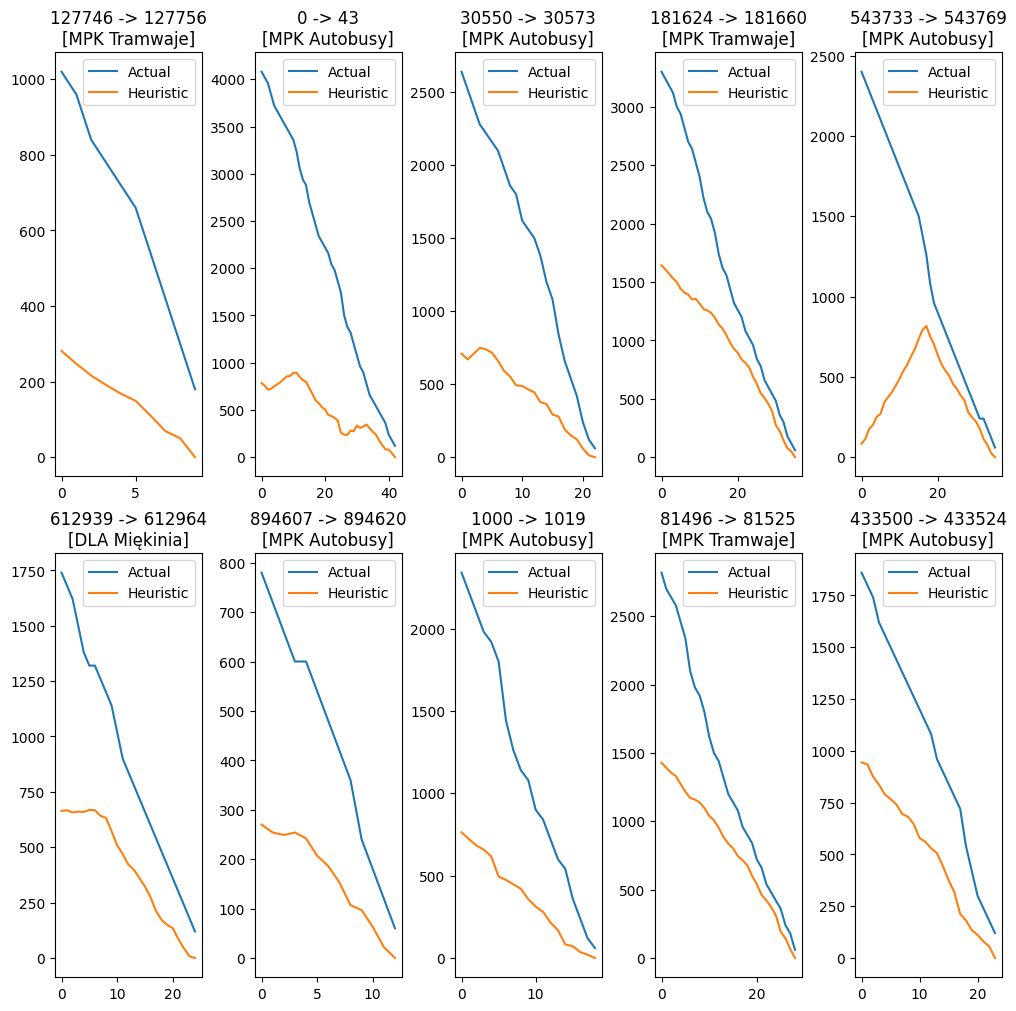

In [10]:
from IPython.display import Image
Image(filename=DATA_DIR / 'time_heuristic_test.png')

In [11]:
conn, sol_cost, elapsed_time = a_star_solution('DWORZEC NADODRZE', 'Młodych Techników', '16:00:00', 't')

C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\searching\searchning.py:131: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv',


In [12]:
print_path(conn)
print(f"{sec_to_time(sol_cost)}, {elapsed_time:.2f}s")

(0) DWORZEC NADODRZE [16:00:00] --- 14 ---> Paulińska [16:02:00] [255474]
(1) Paulińska [16:02:00] --- 144 ---> Dubois [16:04:00] [818315]
(2) Dubois [16:04:00] --- 144 ---> Pomorska [16:06:00] [818316]
(3) Pomorska [16:06:00] --- 144 ---> Kępa Mieszczańska [16:08:00] [818317]
(4) Kępa Mieszczańska [16:08:00] --- 144 ---> PL. JANA PAWŁA II [16:10:00] [818318]
(5) PL. JANA PAWŁA II [16:10:00] --- 13 ---> Młodych Techników [16:12:00] [232310]
00:12:00, 5.53s


In [13]:
a_star_t = pd.read_csv(RESULTS / 'a-star-t/summary0', names=header)

#### Porównanie wyników Dijkstry i A*

Czasy przejazdów $A*t$ i Dijkstry są - oprócz jednego wyjątku - takie same. Wyjątkiem jest tutaj połączenie 'Wilczyce - Dębowa -> Marszowicka', jednak różnica wynosi tylko 1 minutę. Wynika ona prawdopodobnie z heurystyki, która chwilowo mogła być nieoptymalna i poprowadziła w nieco gorszym kierunku. To jednak pokazuje, że heurystyka musiałaby być o wiele bardziej skomplikowana, by była zawsze optymistyczna. 
W przypadku czasu obliczeń $A*t$ daje znaczącą poprawę. 


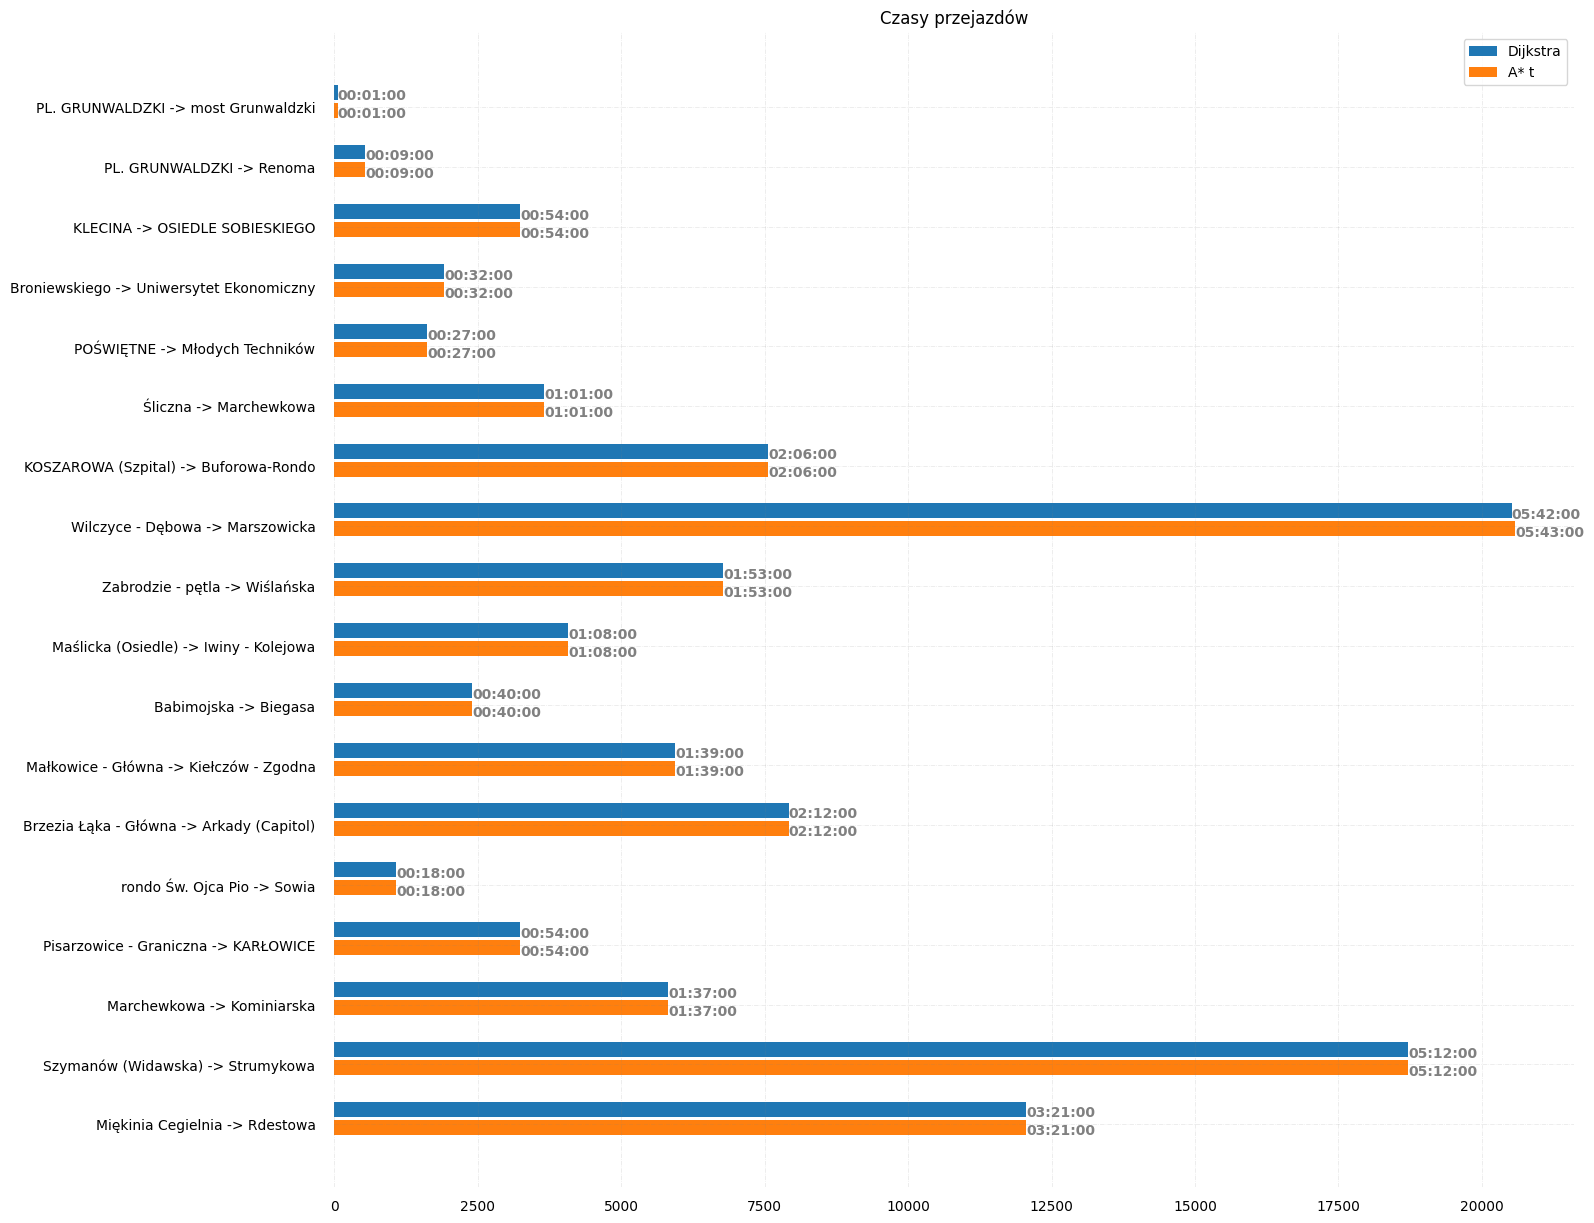

In [14]:
bar_plot_compare([dij, a_star_t], ['Dijkstra', 'A* t'], col_idx=2, title='Czasy przejazdów', formatter=time_to_normalized_sec, display_annotation=True)

W pierwszym przypadku poniżej różnica prawdopodobnie wynika z tego, że algorytmy mają różną implementację, co się uwidacznia dla krótkich połączeń

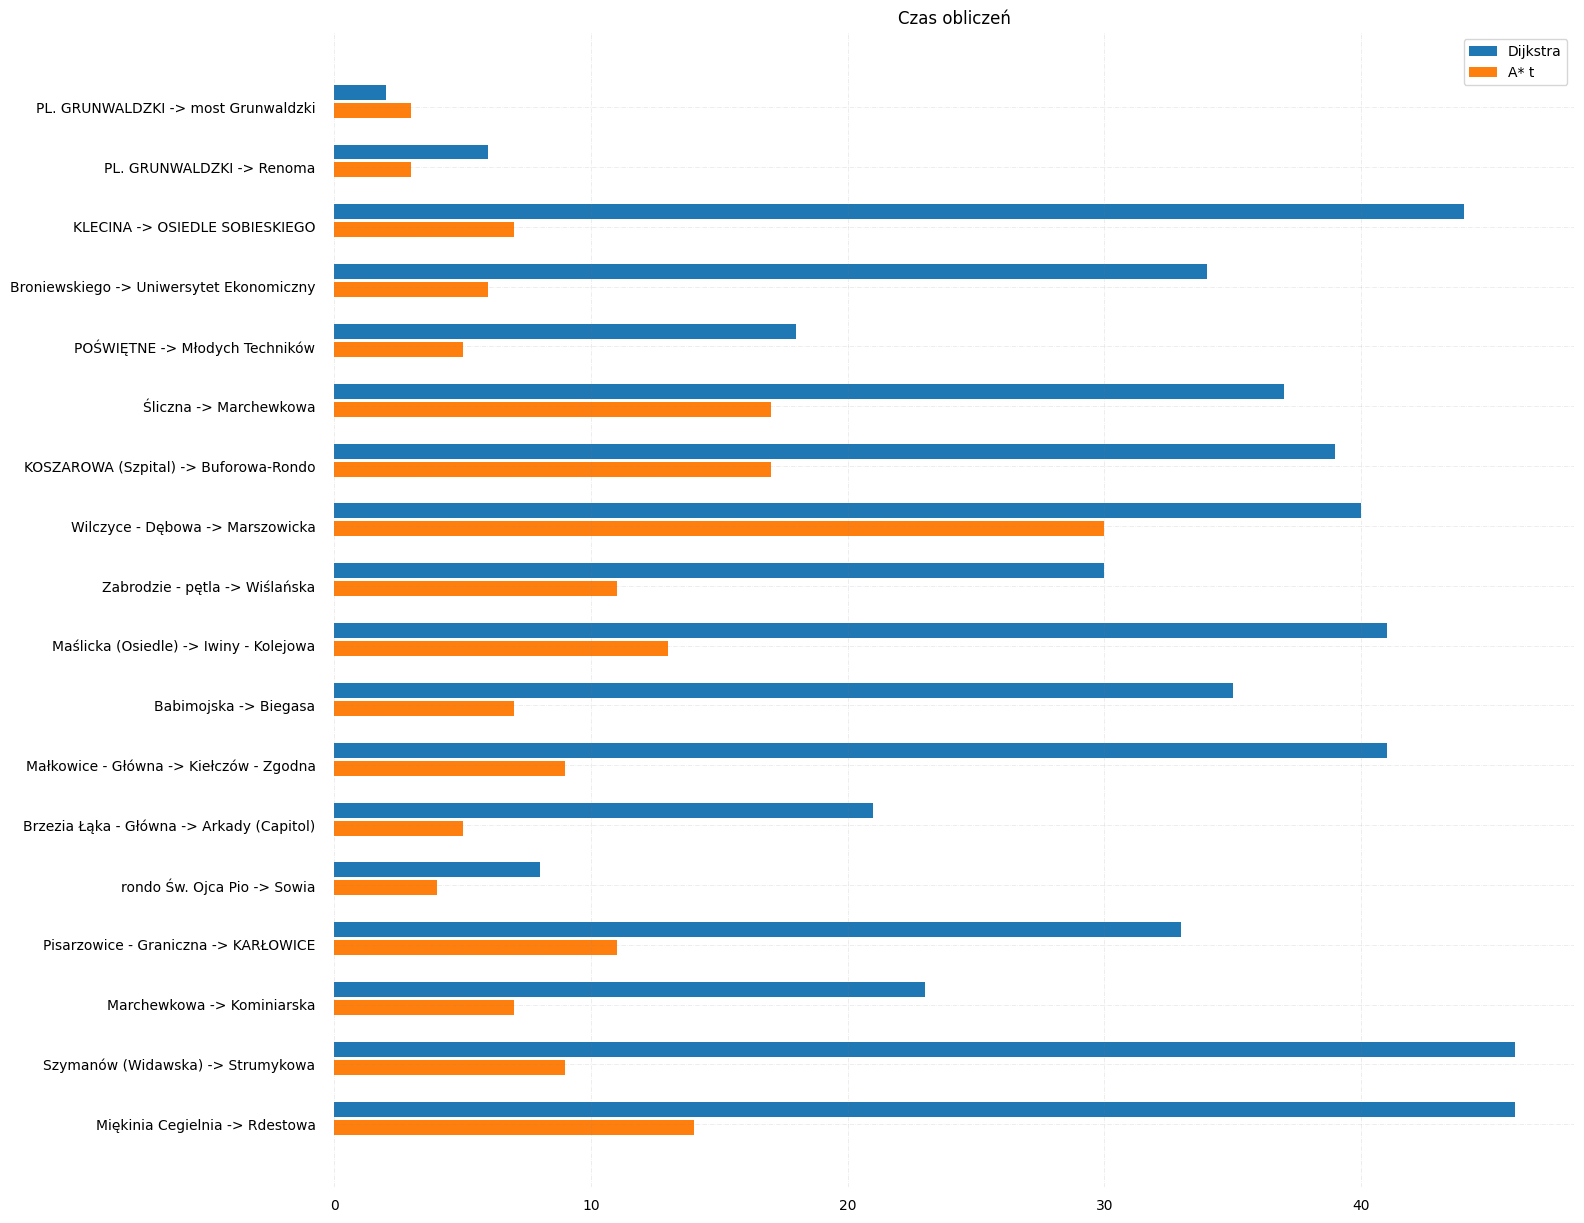

In [15]:
bar_plot_compare([dij, a_star_t], ['Dijkstra', 'A* t'], col_idx=4, title='Czas obliczeń', formatter=int, display_annotation=False)

#### Modyfikacja - dodanie czasu przesiadki 

W celu urealnienia sytuacji zmiany linii dodano do algorytmów stałą wartość przesiadki - 1 min. W niektórych przypadkach zwiększyło to całkowity czas przejazdu i zmieniło liczbę przesiadek. 

In [16]:
a_star_t_60 = pd.read_csv(RESULTS / 'a-star-t/summary60', names=header)
dij_60 = pd.read_csv(RESULTS / 'dijkstra/summary60', names=header)

#### Porównanie $A*t$ z i bez czasu przesiadki

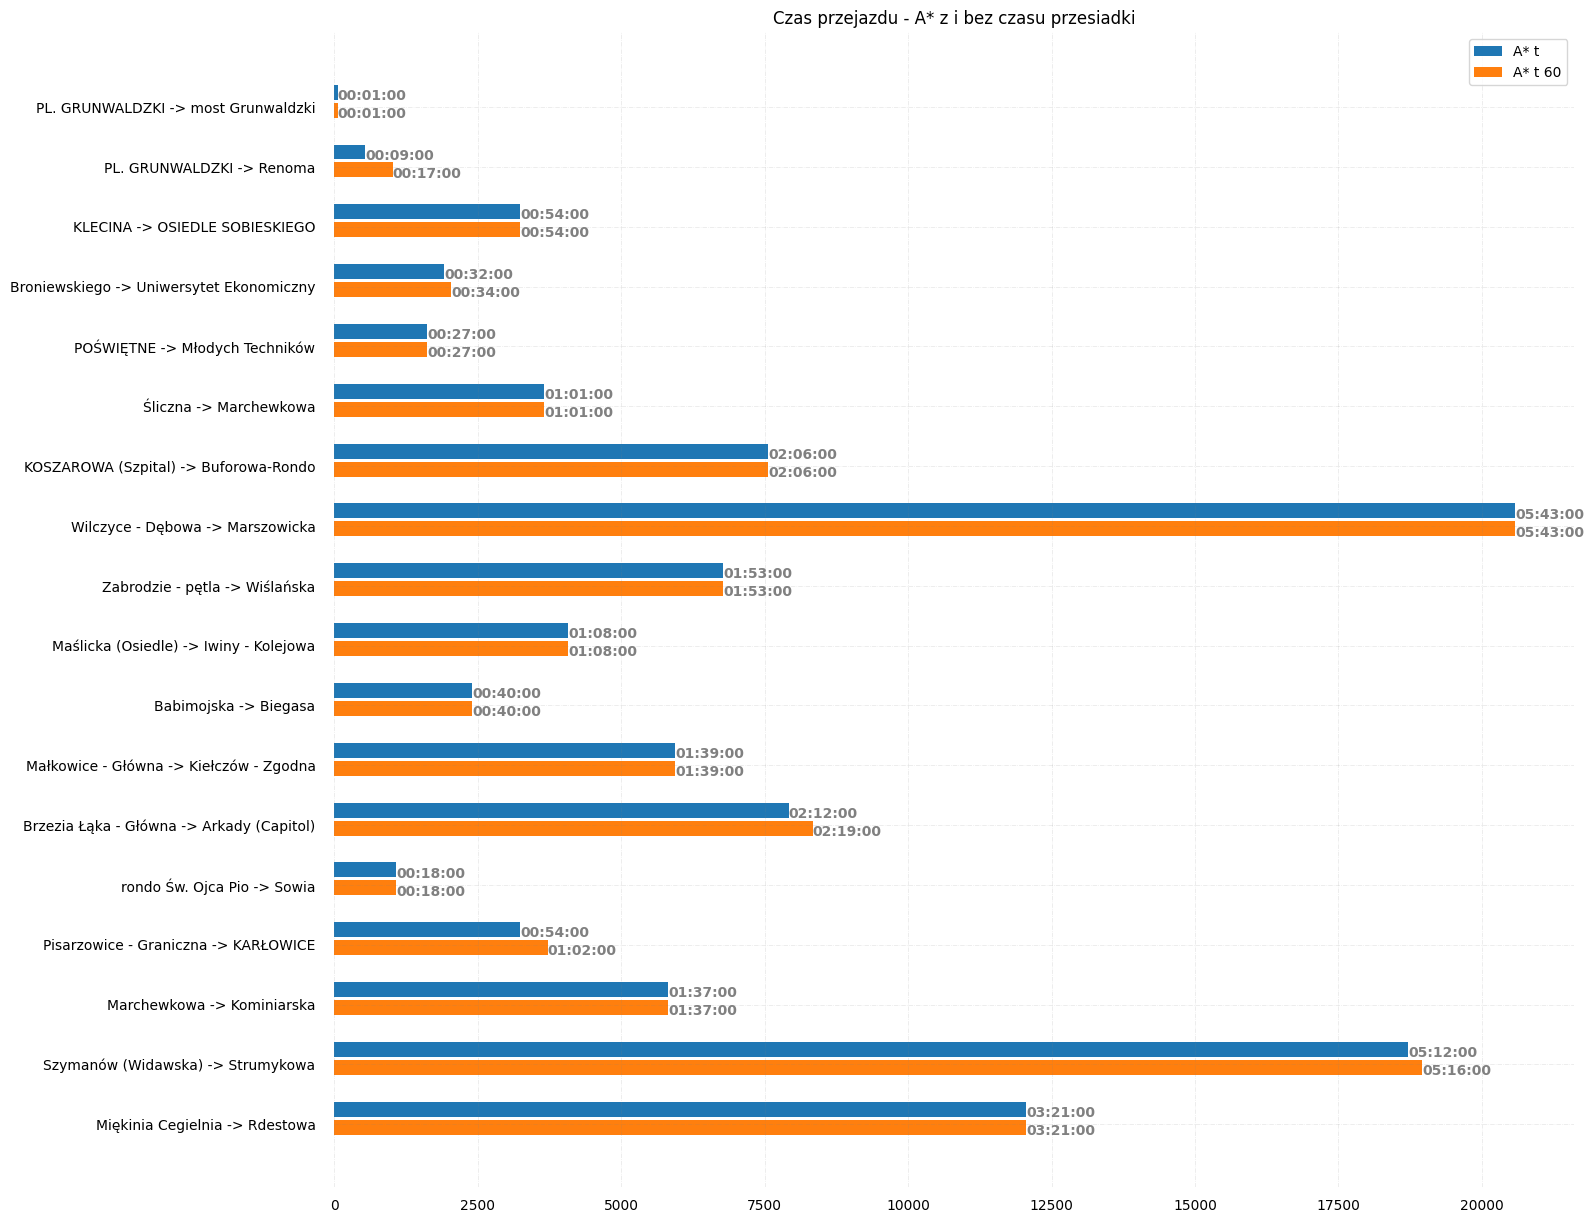

In [17]:
bar_plot_compare([a_star_t, a_star_t_60], ['A* t', 'A* t 60'], col_idx=2, title='Czas przejazdu - A* z i bez czasu przesiadki', 
                 formatter=time_to_normalized_sec, display_annotation=True)

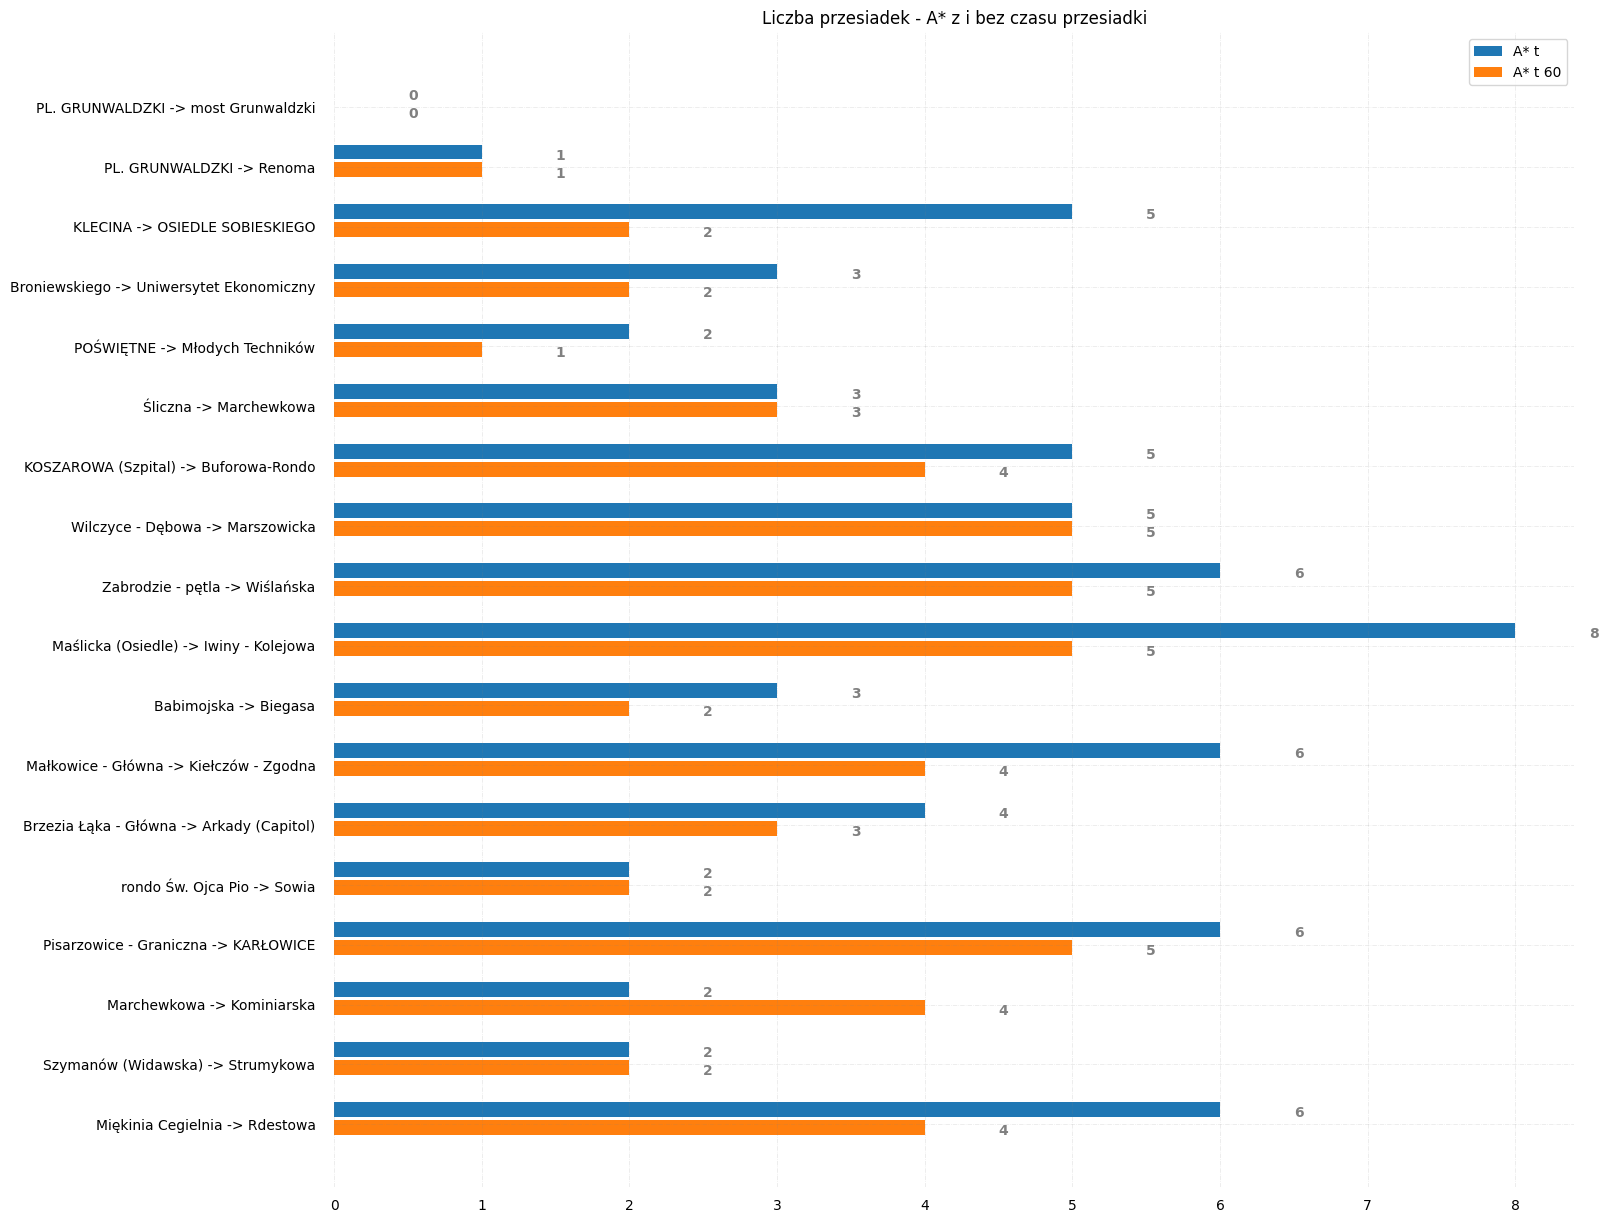

In [18]:
bar_plot_compare([a_star_t, a_star_t_60], ['A* t', 'A* t 60'], col_idx=3, title='Liczba przesiadek - A* z i bez czasu przesiadki', 
                 formatter=int, display_annotation=True)

#### Porównianie Dijsktry z i bez czasu przesiadki

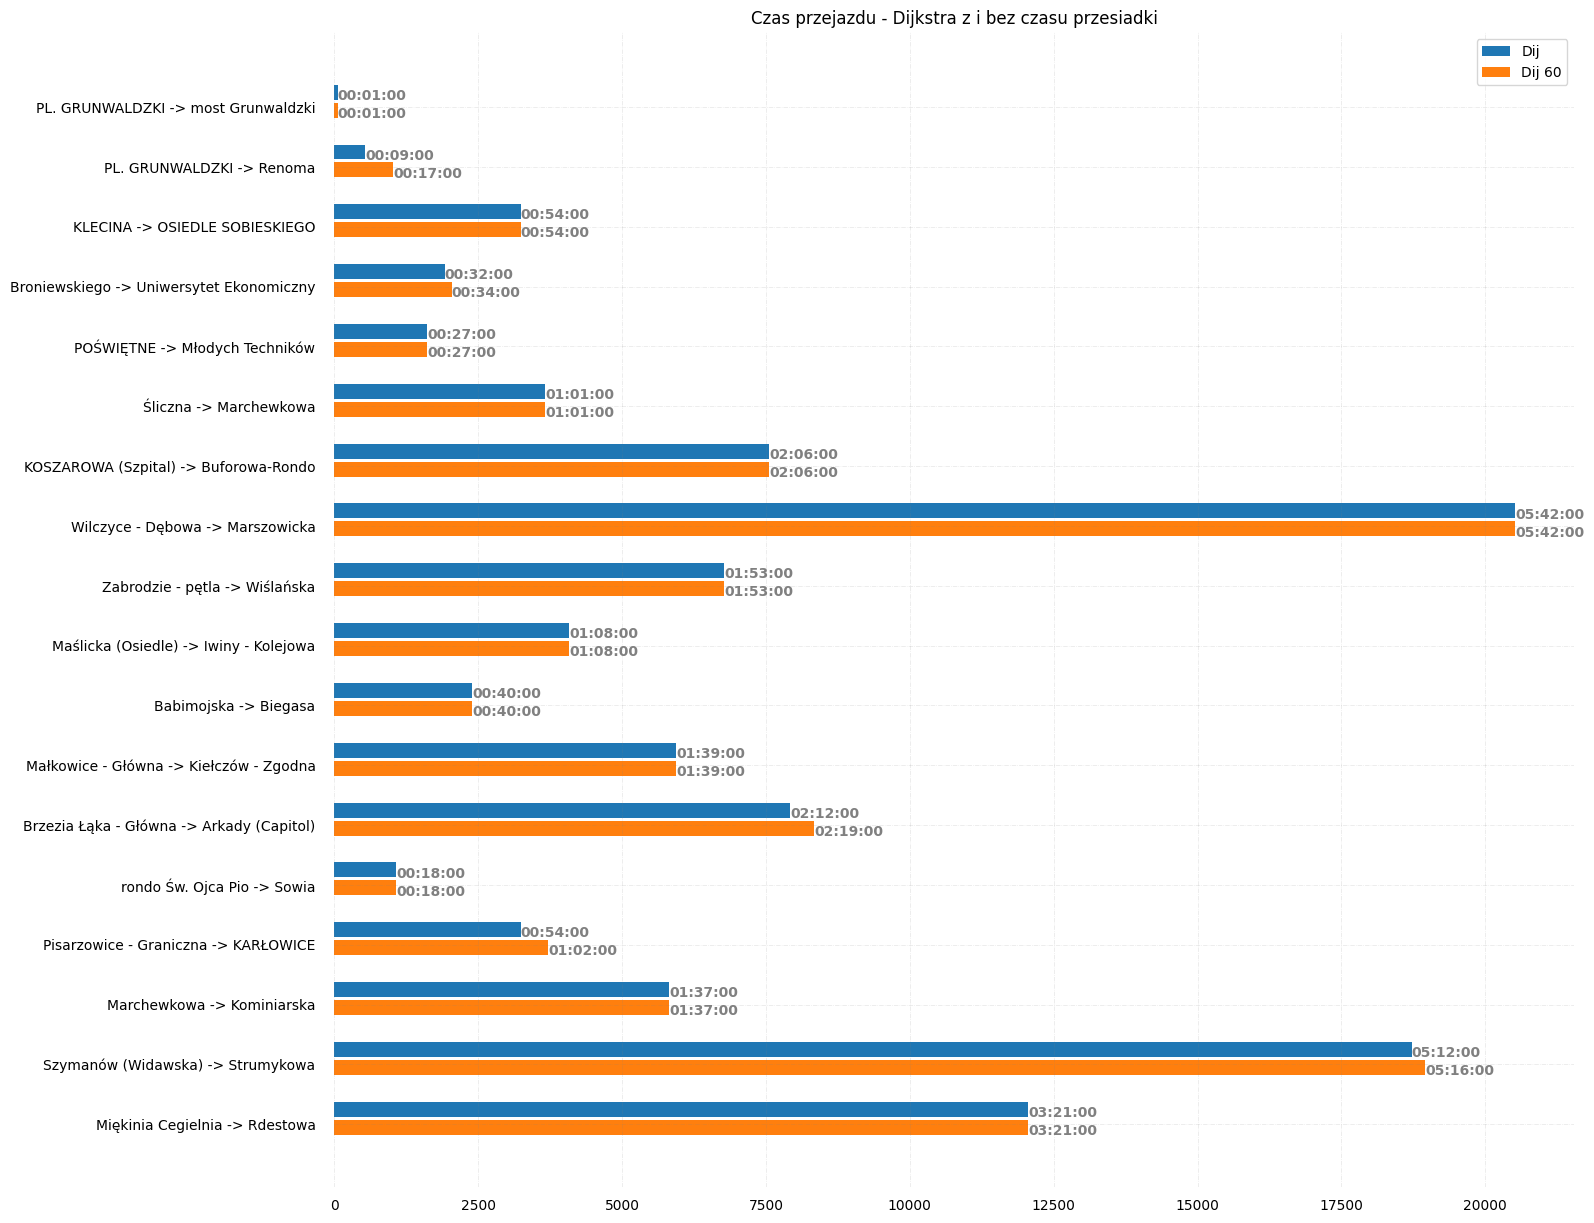

In [19]:
bar_plot_compare([dij, dij_60], ['Dij', 'Dij 60'], col_idx=2, title='Czas przejazdu - Dijkstra z i bez czasu przesiadki', 
                 formatter=time_to_normalized_sec, display_annotation=True)

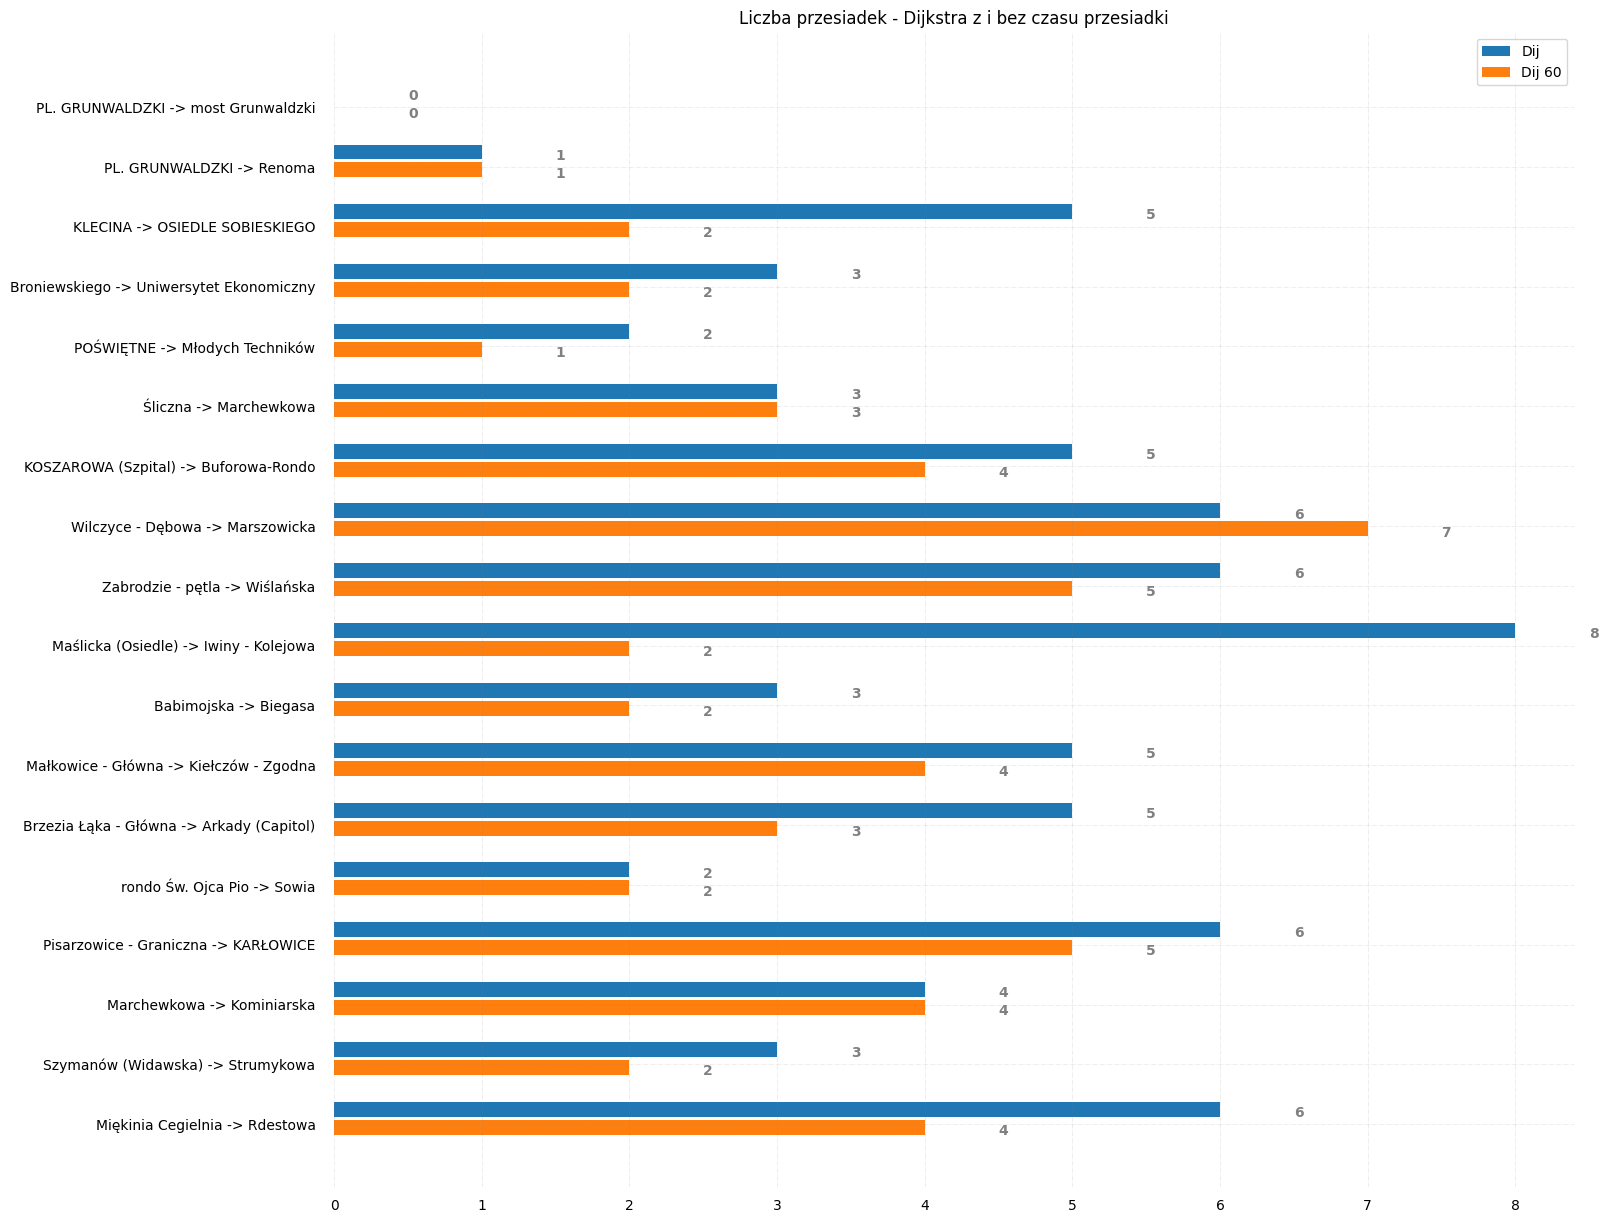

In [20]:
bar_plot_compare([dij, dij_60], ['Dij', 'Dij 60'], col_idx=3, title='Liczba przesiadek - Dijkstra z i bez czasu przesiadki', 
                 formatter=int, display_annotation=True)

#### Optymalizacja przesiadek
Ta postać problemu była bardziej skomplikowana ponieważ definicja przesiadki nie jest oczywista. W tym przypadku uznano, że doszło do przesiadki gdy
> - nastąpiła zmiana lini
> - nastąpiło przejście do sąsiedniego przystanku
> - czas między przyjazdem a odjazdem jest 'długi' (bez tego wpadamy w przejazdy z innego kursu), jako maksymalną długość przejazdu między przystankami przyjęto 99 percentyl czasu między przejazdami dla tego zbioru, czyli 4 minuty.

Heurystyka polega na oszacowaniu liczby przesiadek w zależności od odległości od przystanku końcowego i aktualnej, już dokonanej liczby przesiadek. Heurystyka również faworyzuje początkowe połączenie, które jest najszybciej (tj. by zacząć podróż jak najszybciej).

Reprezentacja połączeń różni się od $A^* t$ tym, że przeszukujemy wszystkie możliwe linie wychodzące z danego przystanku, jak i zachowujemy informację o lini w węźle grafu. 

In [21]:
conn, sol_cost, elapsed_time = a_star_solution('DWORZEC NADODRZE', 'Młodych Techników', '16:00:00', 'p')

C:\Users\julia\VSCode\AI-and-Data-Engineering\ai_data_eng\searching\searchning.py:131: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  connection_graph = pd.read_csv(DATA_DIR / 'connection_graph.csv',


In [22]:
print_path(conn)
print(f"{sol_cost}, {elapsed_time:.2f}s")

(0) DWORZEC NADODRZE [16:11:00] --- 132 ---> Paulińska [16:13:00] [735117]
(1) Paulińska [16:13:00] --- 132 ---> Dubois [16:16:00] [735118]
(2) Dubois [16:16:00] --- 132 ---> Rynek [16:21:00] [735119]
(3) Rynek [16:21:00] --- 132 ---> PL. JANA PAWŁA II [16:24:00] [735120]
(4) PL. JANA PAWŁA II [16:24:00] --- 132 ---> Młodych Techników [16:26:00] [735121]
0, 6.26s


In [23]:
a_star_p = pd.read_csv(RESULTS / 'a-star-p/summary0', names=header)

In [24]:
a_star_p.head()

,start_stop,goal_stop,commuting_time,changes,elapsed_time,cost,change_time
0,PL. GRUNWALDZKI,most Grunwaldzki,00:01:00,0,3.28,0,0
1,PL. GRUNWALDZKI,Renoma,00:09:00,0,3.59,0,0
2,KLECINA,OSIEDLE SOBIESKIEGO,00:54:00,0,7.43,0,0
3,Broniewskiego,Uniwersytet Ekonomiczny,00:37:00,0,8.43,0,0
4,POŚWIĘTNE,Młodych Techników,13:11:00,1,5.92,1,0


#### Porównanie $A*t$ i $A*p$

Widać znaczący wzrost czasu przejazdu, jak i czasu obliczeń $A*p$ w stosunku do $A*t$. Jednak liczba przesiadek znacząco się zmniejszyła do maksymalnie 3, a w niektórych przypadkach mamy aż o 5 przesiadek mniej. 

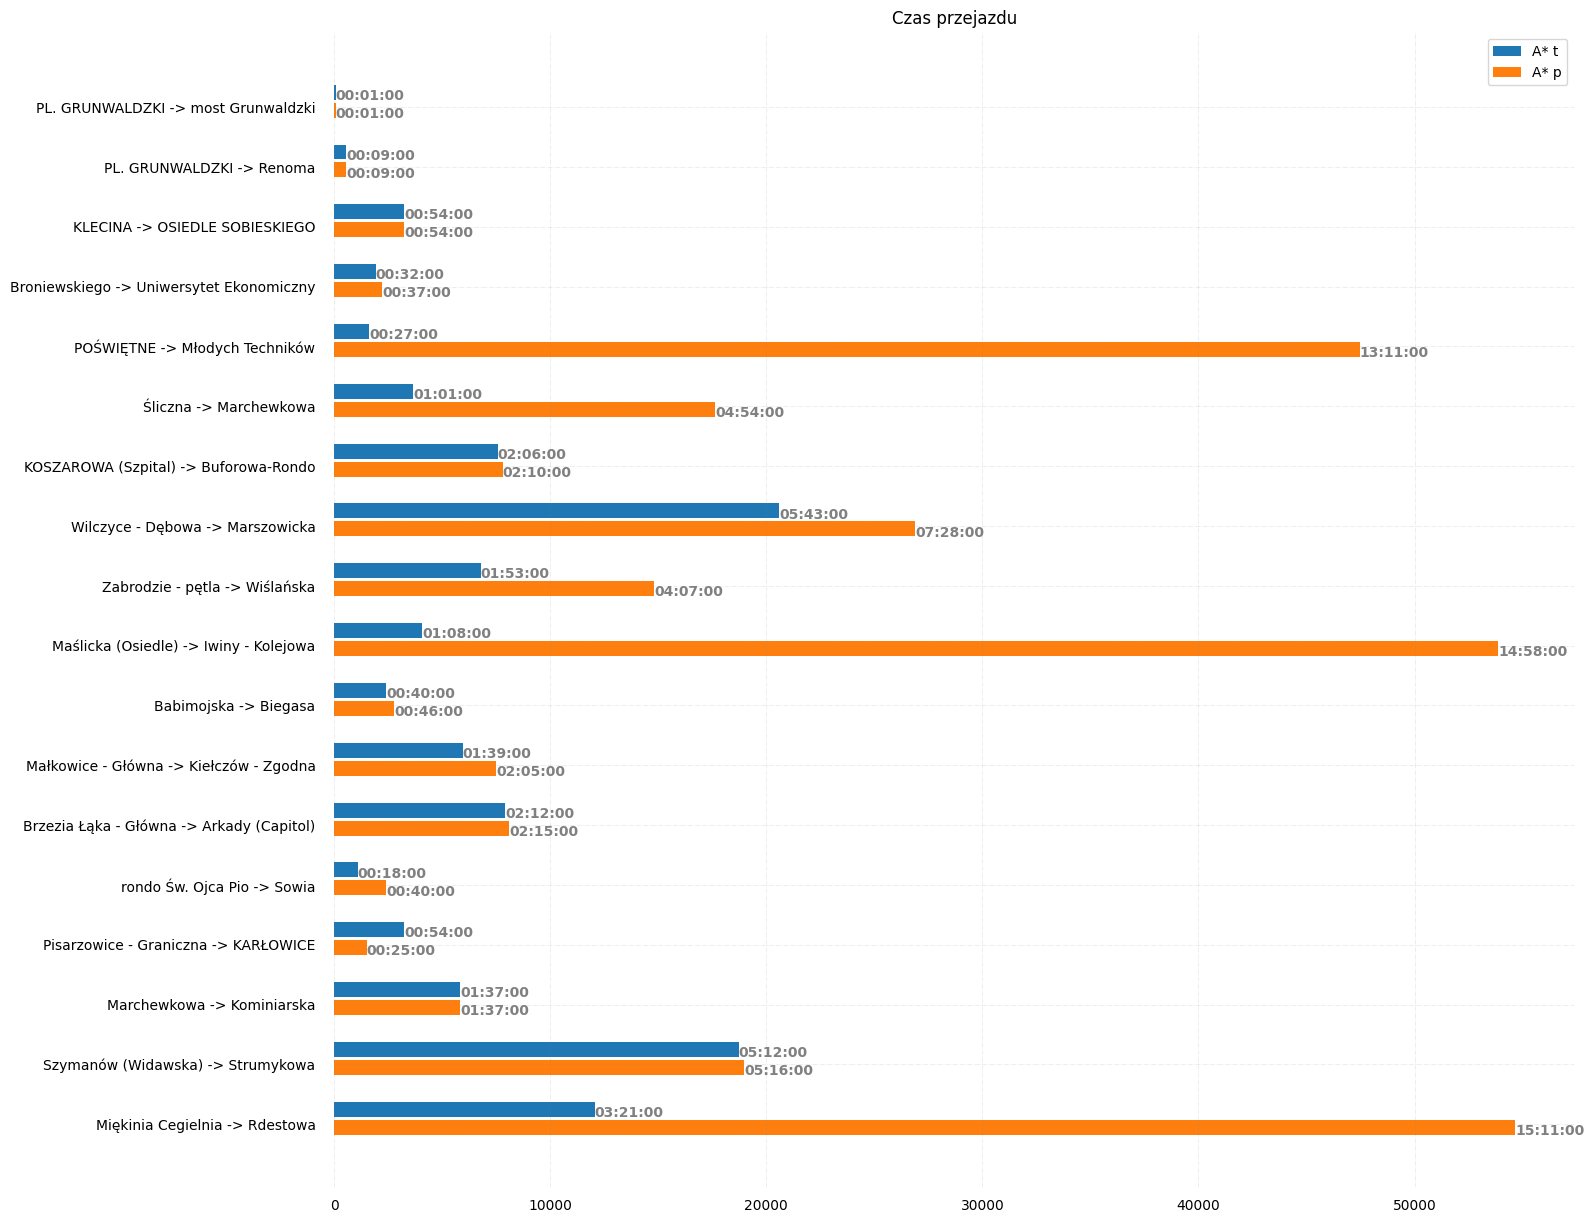

In [25]:
bar_plot_compare([a_star_t, a_star_p], ['A* t', 'A* p'], col_idx=2, title='Czas przejazdu', formatter=time_to_normalized_sec, display_annotation=True)

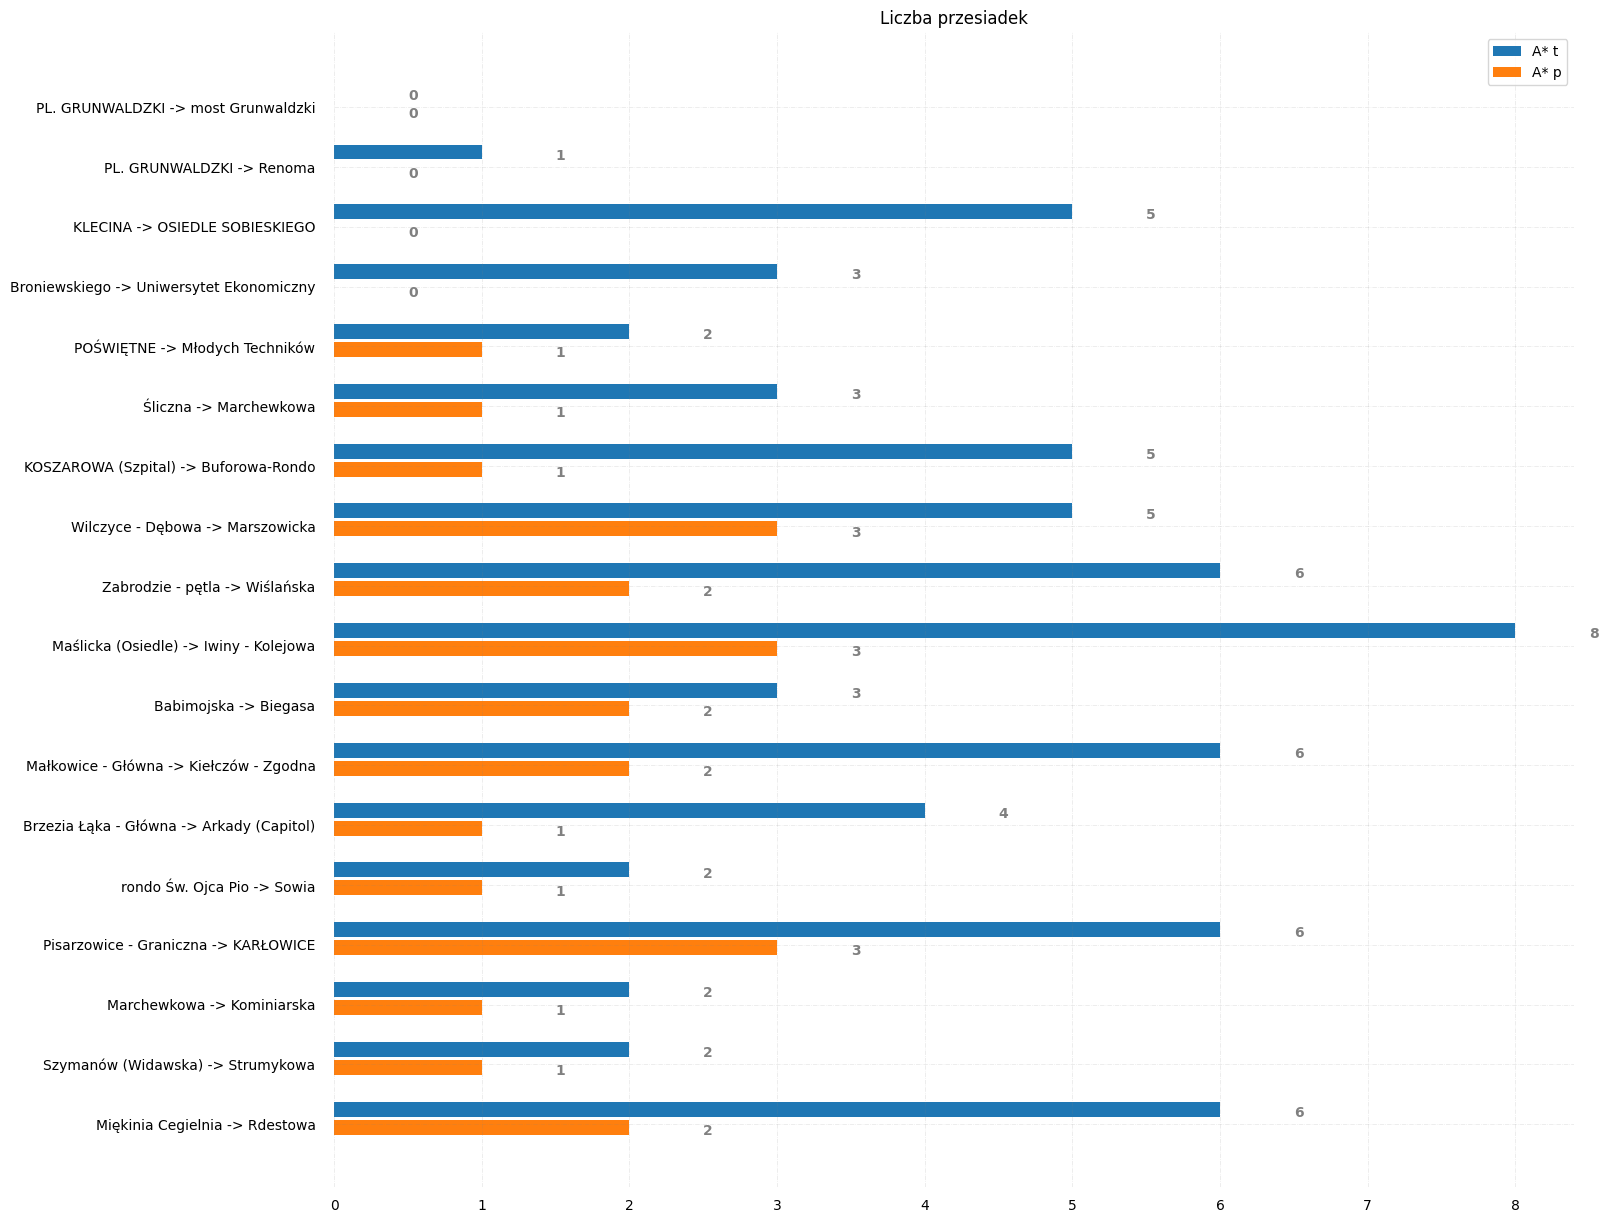

In [26]:
bar_plot_compare([a_star_t, a_star_p], ['A* t', 'A* p'], col_idx=3, title='Liczba przesiadek', formatter=int, display_annotation=True)

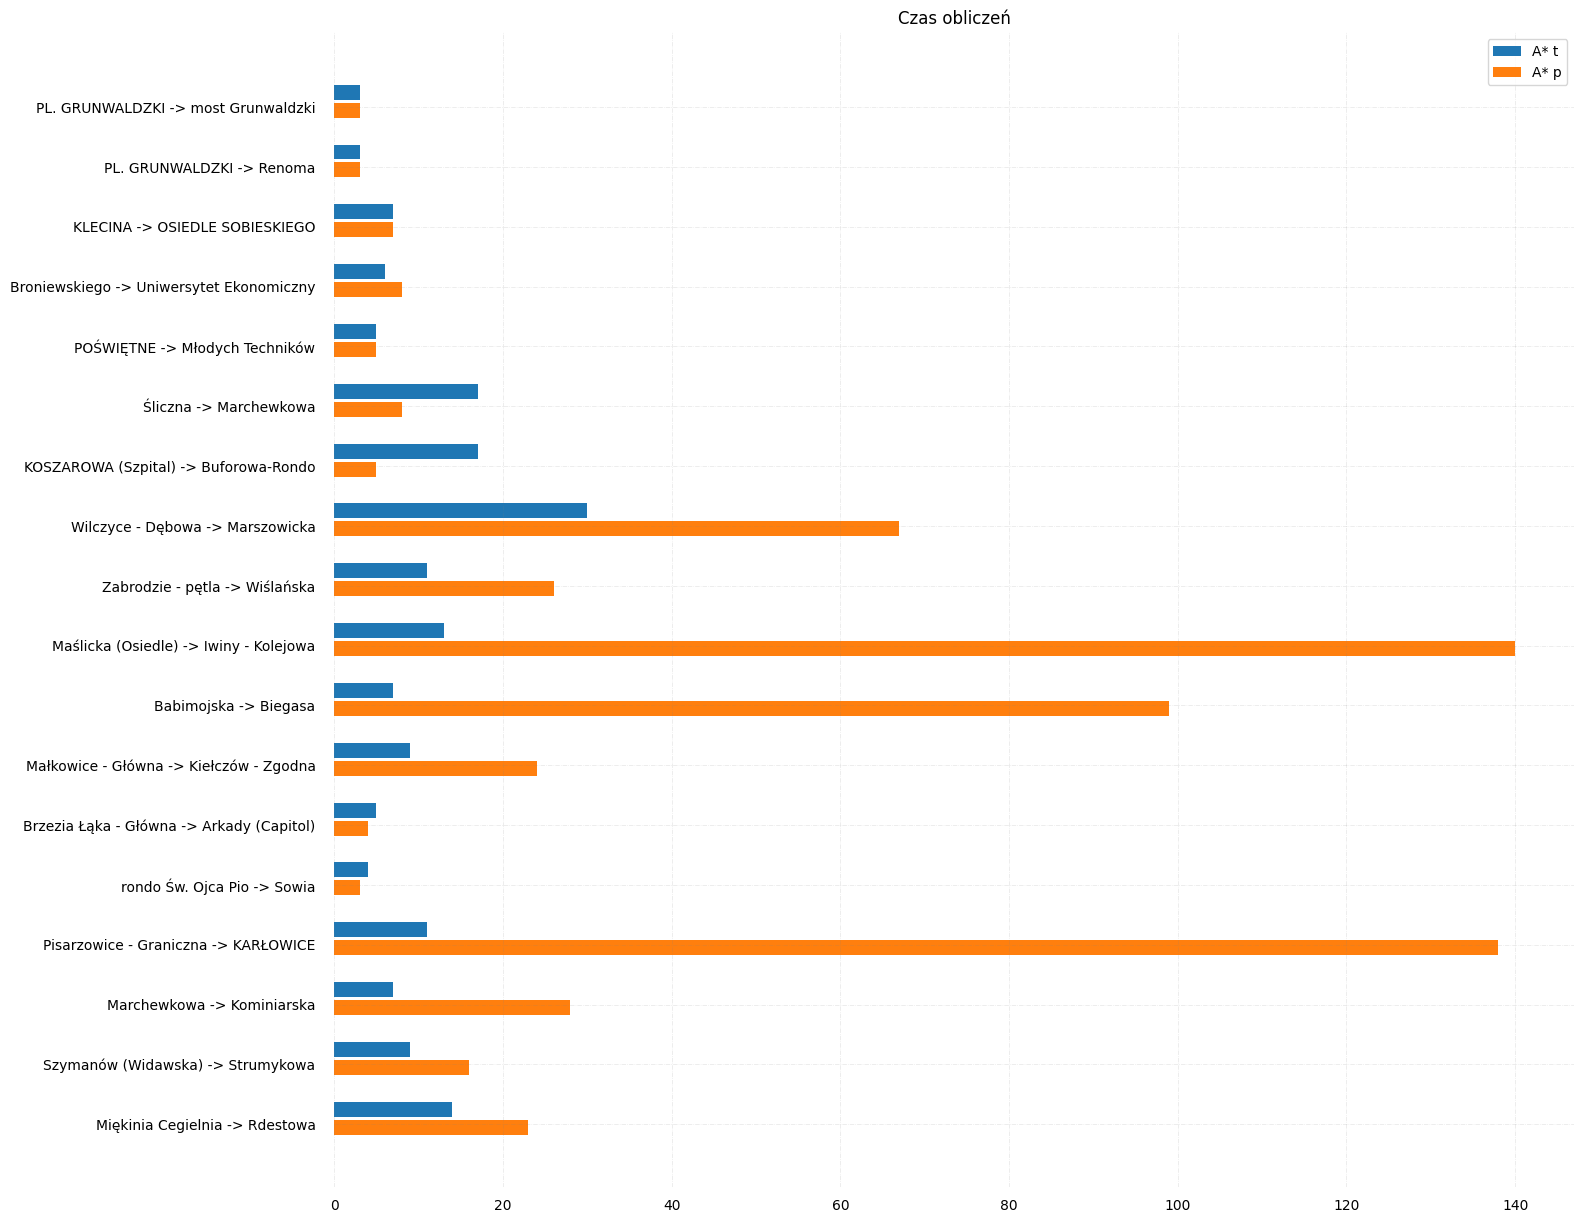

In [27]:
bar_plot_compare([a_star_t, a_star_p], ['A* t', 'A* p'], col_idx=4, title='Czas obliczeń', formatter=int, display_annotation=False)

#### Modyfikacja - optymalizacja czasu i liczby przesiadek 

Modyfikacja dotyczyła zaimplementowania nowej funkcji kosztu i heurystyki, które liczą średnią ważoną kosztów czasu przejazdu i przesiadek A$^*$. Porównując wyniki do $A^* t$ można zauważyć, że odnajduje on prawie tak samo optymalne pod względem czasowym trasy, oraz w porównaniu do $A^*p$ modyfikuje liczbę przesiadek. Wagi dla obu strat - $0.05$ (t), $1$ (p) -zostały wybrane na podstawie próby o liczebności 2, więc prawdopodobnie możliwe byłoby dobranie lepszych wartości tych hiperparametrów. 

Algorytm osiąga bardzo podobne wyniki do  $A^* t$ jeśli chodzi o czas przejazdu, jednak różnie jest z liczbą przesiadek. 

In [28]:
a_star_t_custom = pd.read_csv(RESULTS / 'a-star-custom/summary0', names=header)

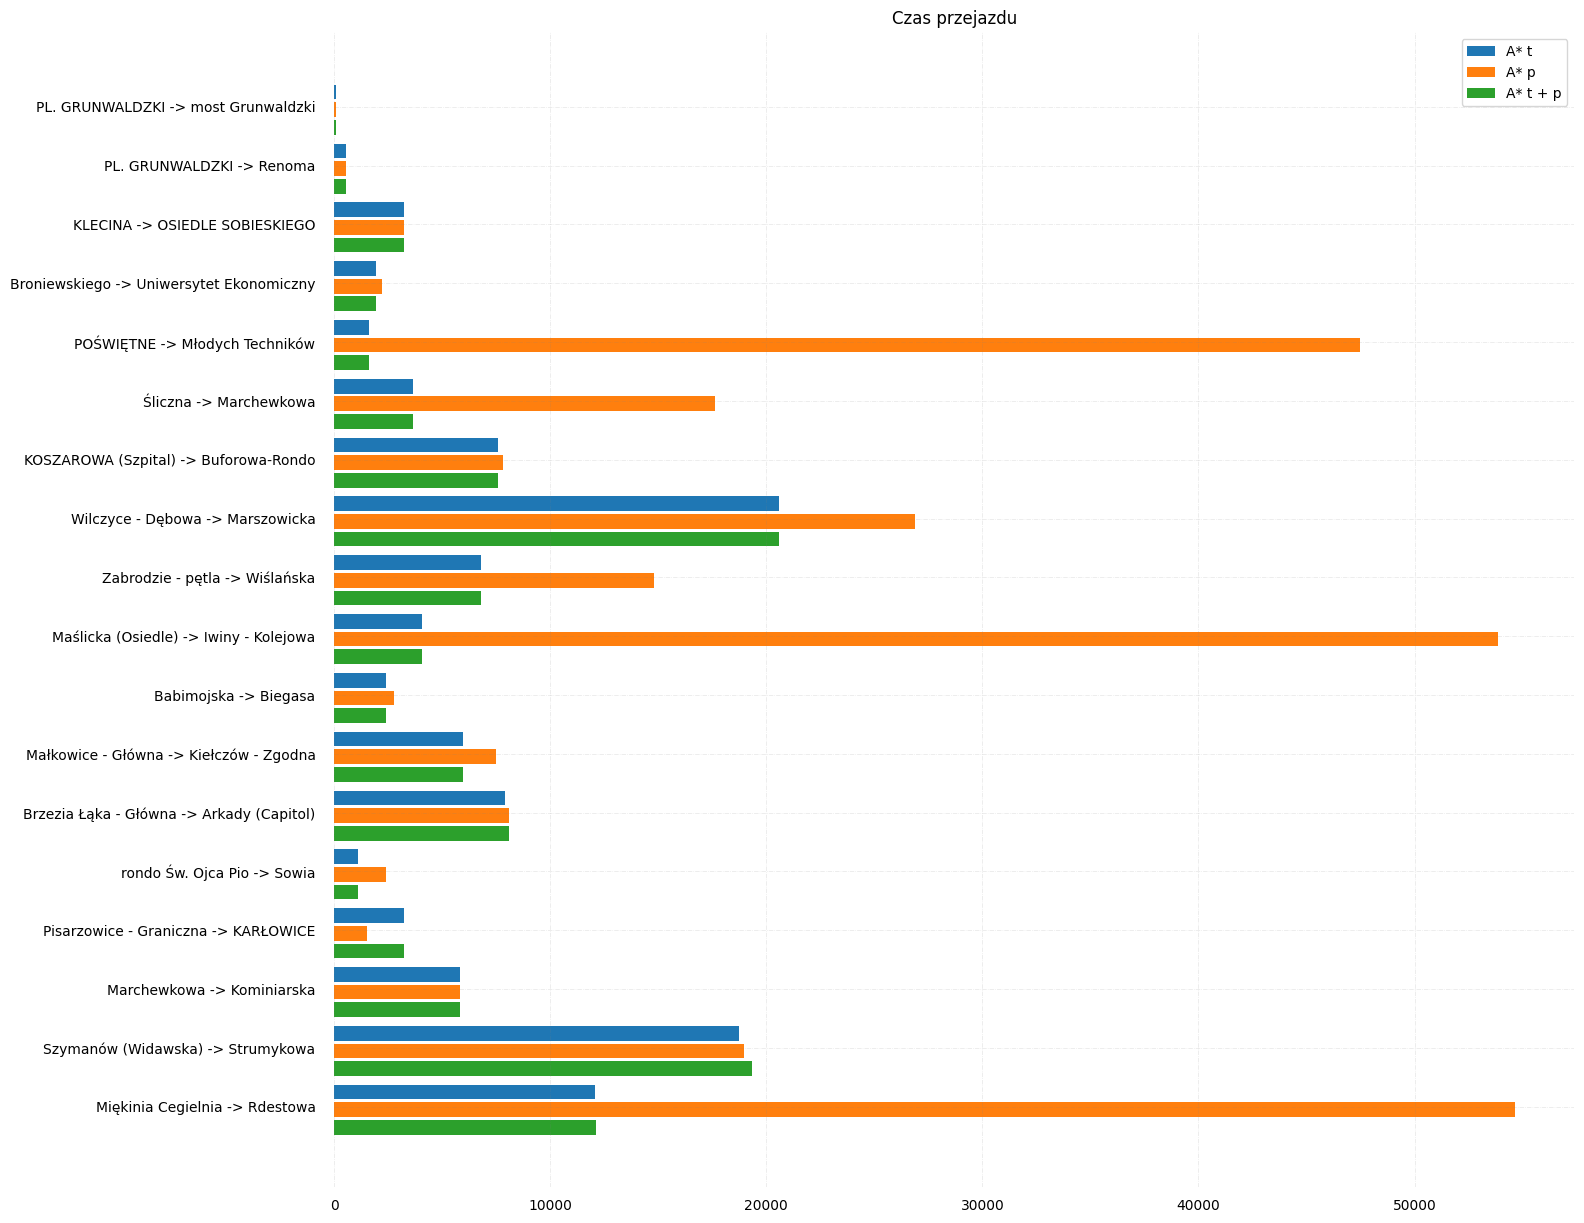

In [29]:
bar_plot_compare([a_star_t, a_star_p, a_star_t_custom], ['A* t', 'A* p', 'A* t + p'], col_idx=2, title='Czas przejazdu', formatter=time_to_normalized_sec, display_annotation=False)

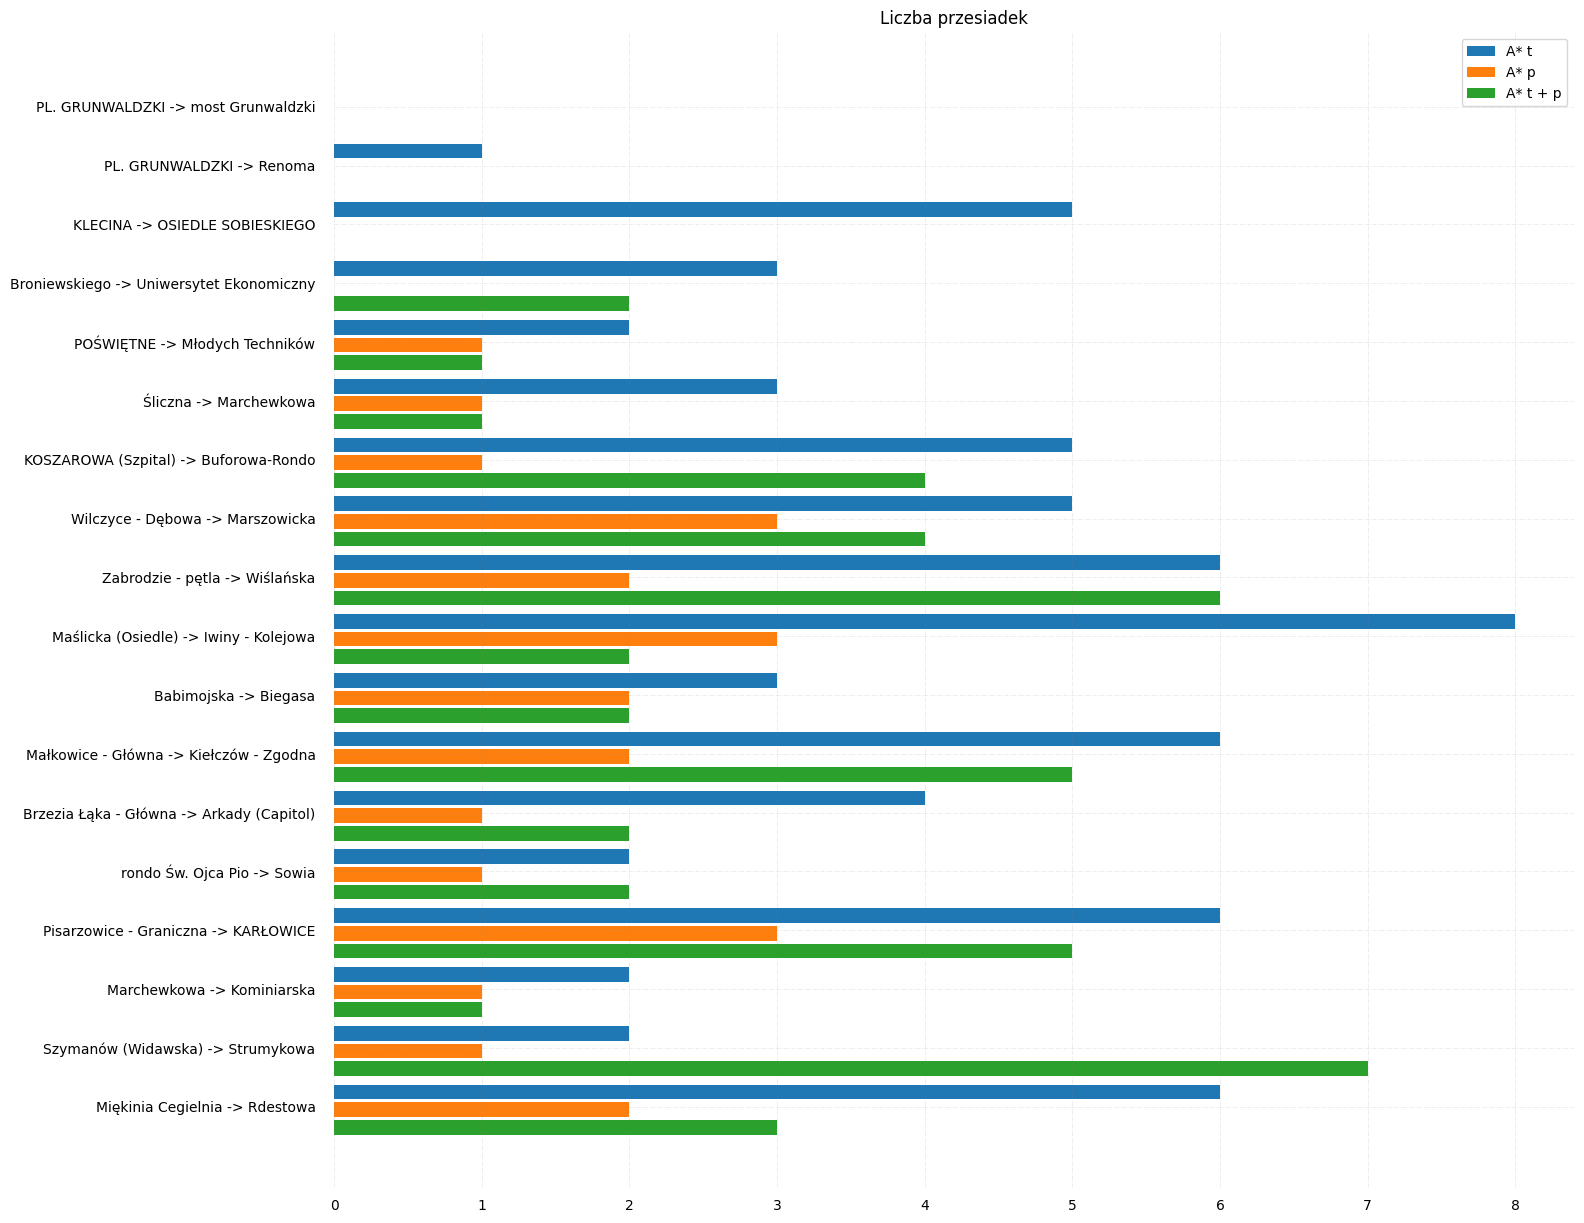

In [30]:
bar_plot_compare([a_star_t, a_star_p, a_star_t_custom], ['A* t', 'A* p', 'A* t + p'], col_idx=3, title='Liczba przesiadek', formatter=int, display_annotation=False)

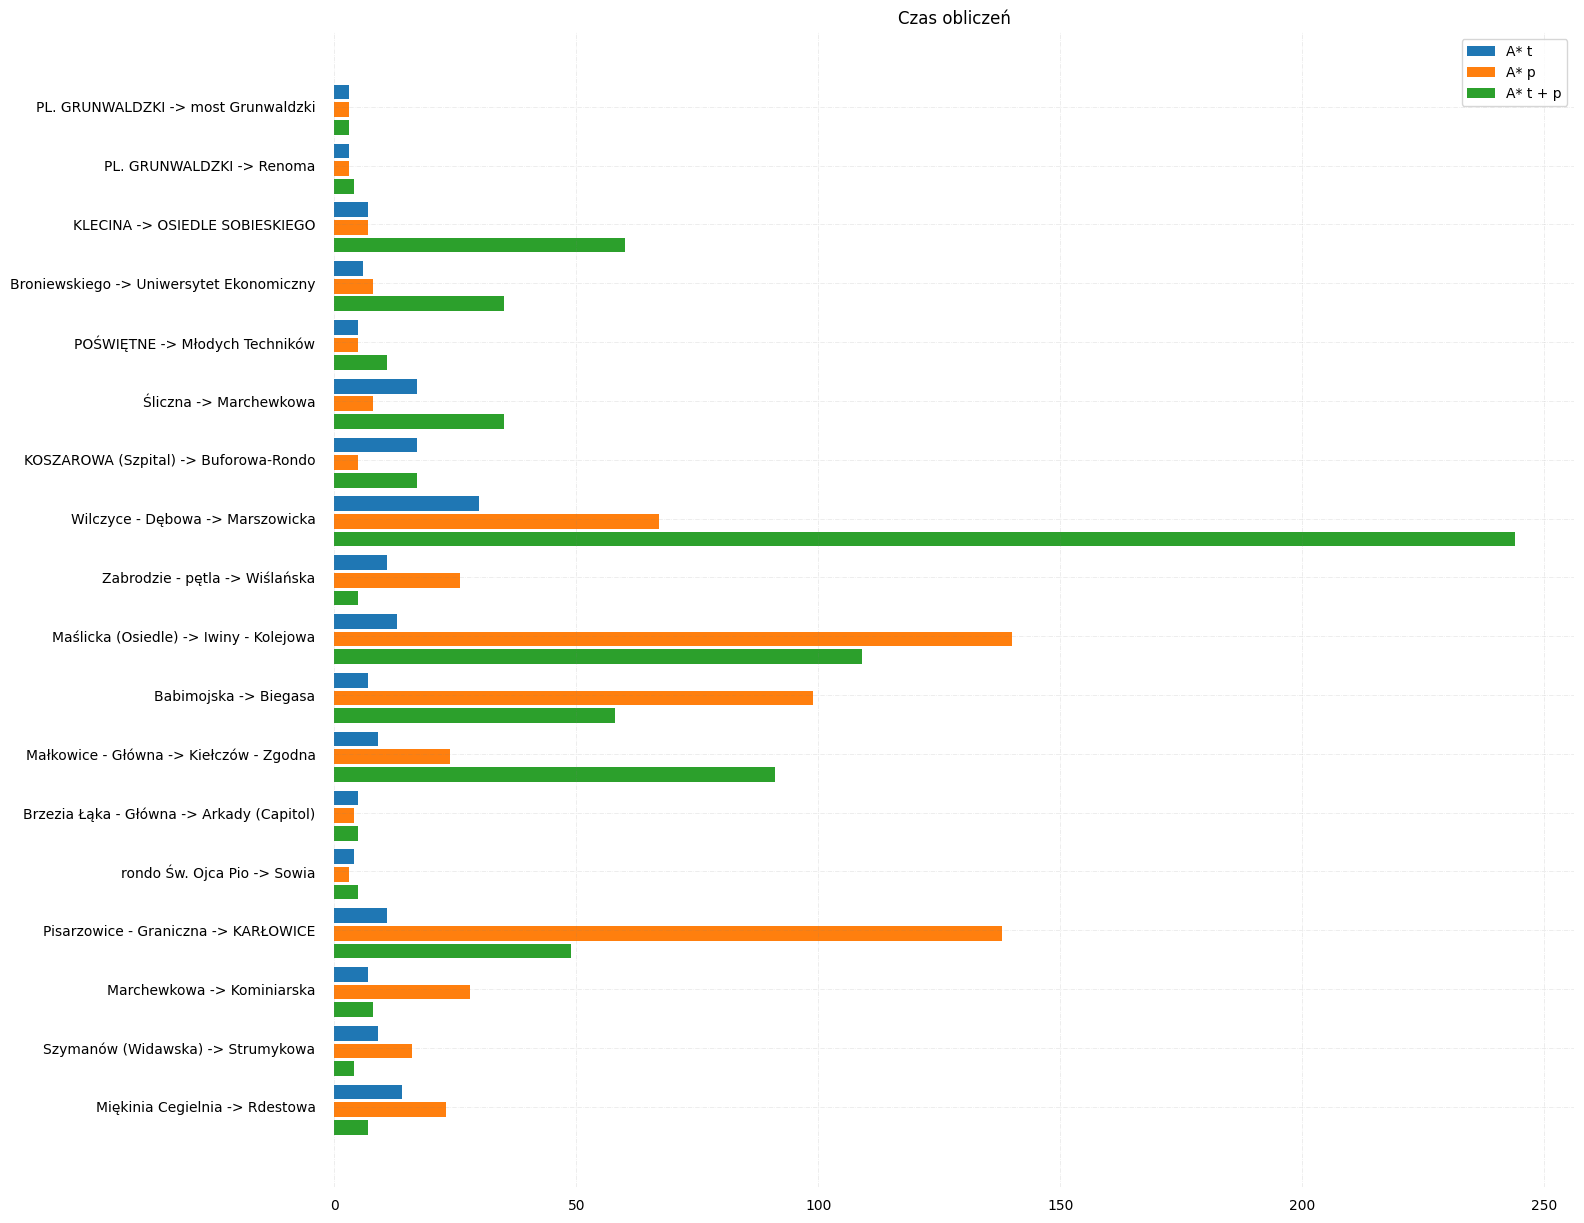

In [31]:
bar_plot_compare([a_star_t, a_star_p, a_star_t_custom], ['A* t', 'A* p', 'A* t + p'], col_idx=4, title='Czas obliczeń', formatter=int, display_annotation=False)

### Tabu Search

Problem przeszukiwania lokalnego został rozwiązany w następujący sposób:
> 1. Generowane jest początkowe rozwiązanie, które jest połączeniem rozwiązań A* dla dwóch kolejnych par przystanków
> 2. Następnie rozwiązanie jest poprawiane poprzez permutację, która jest aplikowana od początku ścieżki 
> 3. Następnie w zagnieżdżonych pętlach (co odpowiada przeszukiwaniu sąsiedztwa) szukamy lepszego rozwiazania - jeśli go znajdziemy, to zaczynamy przeprowadzać permutacje od początku na tym rozwiązaniu

Permutacja polega na zmianie ścieżki $A -> B -> C$ na $B -> A -> C$, gdzie $B$ i $C$ są przystankami z listy $L$ przystanków do odwiedzenia. W ten sposób jest bardziej prawdopodobne, że permutowane rozwiązanie będzie *poprawne*, tj. uwzględni wszystkie przystanki z listy $L$.

Ostatni krok w tym podejściu jednak skraca liczbę permutacji, przez co możemy jakiegoś bardziej optymalnego rozwiązania nie znaleźć. Było to jednak potrzebne o tyle, że algorytm baardzo długo się przeliczał. 

In [44]:
from ai_data_eng.tabu_search.globals import TABU_SEARCH_DIR_TIME, TABU_SEARCH_DIR_CHANGES

cases = pd.read_json(DATA_DIR / 'test_cases/tabu-search-cases.json')
results_t = pd.read_json(TABU_SEARCH_DIR_TIME / 'summary.json')

In [45]:
cases

,start_stop,visiting_stops,leave_hour
0,PL. GRUNWALDZKI,"[most Grunwaldzki, Tramwajowa]",09:00:00
1,GALERIA DOMINIKAŃSKA,"[DWORZEC AUTOBUSOWY, Niedźwiedzia, Tarnogajska]",15:30:00
2,PL. GRUNWALDZKI,"[Krucza, Trzebnicka, Renoma, most Grunwaldzki]",08:00:00
3,Smolecka,"[most Milenijny, Muchobór Wielki, Cynamonowa]",20:30:00


In [46]:
results_t[['commute_time', 'n_of_changes', 'best_sol_iteration', 'solutions_probed', 'iterations', 'elapsed_time']]

,commute_time,n_of_changes,best_sol_iteration,solutions_probed,iterations,elapsed_time
0,1080,3,0,1,1,0.00
1,3840,8,3,113,113,615.03
2,4320,8,2,53,54,434.99
3,5400,5,7,53,52,1452.59


In [47]:
for i in range(len(results_t)):
    print(f"TEST CASE {cases.loc[i, 'start_stop']} with stops {cases.loc[i, 'visiting_stops']}")
    solution = [g.conn_at_index(j) for j in results_t.loc[i, 'conn_idx']]
    print_path_mark_stops(solution, cases.loc[i, 'visiting_stops'])
    print_sol_info(solution, cases.loc[i, 'visiting_stops'])

TEST CASE PL. GRUNWALDZKI with stops ['most Grunwaldzki', 'Tramwajowa']
(0)  PL. GRUNWALDZKI [09:00:00] --- 146 ---> most Grunwaldzki [09:02:00] [851090]
(1) ** most Grunwaldzki [09:02:00] --- 16 ---> PL. GRUNWALDZKI [09:04:00] [280113]
(2)  PL. GRUNWALDZKI [09:04:00] --- 1 ---> Kliniki - Politechnika Wrocławska [09:06:00] [60700]
(3)  Kliniki - Politechnika Wrocławska [09:06:00] --- 1 ---> Hala Stulecia [09:08:00] [60701]
(4)  Hala Stulecia [09:08:00] --- 1 ---> ZOO [09:09:00] [60702]
(5)  ZOO [09:09:00] --- 1 ---> Tramwajowa [09:10:00] [60703]
(6) ** Tramwajowa [09:11:00] --- 4 ---> ZOO [09:13:00] [98160]
(7)  ZOO [09:13:00] --- 4 ---> Hala Stulecia [09:14:00] [98161]
(8)  Hala Stulecia [09:14:00] --- 4 ---> Kliniki - Politechnika Wrocławska [09:16:00] [98162]
(9)  Kliniki - Politechnika Wrocławska [09:16:00] --- 4 ---> PL. GRUNWALDZKI [09:18:00] [98163]
time cost = 00:18:00
changes cost = 3
TEST CASE GALERIA DOMINIKAŃSKA with stops ['DWORZEC AUTOBUSOWY', 'Niedźwiedzia', 'Tarnogajska

In [89]:
results_p = pd.read_json(TABU_SEARCH_DIR_CHANGES / 'summary.json')

In [90]:
results_p

,conn_idx,commute_time,n_of_changes,best_sol_iteration,solutions_probed,iterations,elapsed_time
0,"[107943, 104817, 104818, 104819, 104820, 10482...",1860,2,0,1,1,0.00
1,"[47868, 47869, 344139, 344140, 344141, 344142,...",29040,3,0,55,55,665.36
2,"[14557, 14558, 14559, 14560, 14561, 14562, 895...",81360,4,0,138,138,3738.22


In [91]:
results_p[['commute_time', 'n_of_changes', 'best_sol_iteration', 'solutions_probed', 'iterations', 'elapsed_time']]

,commute_time,n_of_changes,best_sol_iteration,solutions_probed,iterations,elapsed_time
0,1860,2,0,1,1,0.00
1,29040,3,0,55,55,665.36
2,81360,4,0,138,138,3738.22


In [93]:
for i in range(len(results_p)):
    print(f"TEST CASE {cases.loc[i, 'start_stop']} with stops {cases.loc[i, 'visiting_stops']}")
    solution = [g.conn_at_index(j) for j in results_p.loc[i, 'conn_idx']]
    print_path_mark_stops(solution, cases.loc[i, 'visiting_stops'])
    print_sol_info(solution, cases.loc[i, 'visiting_stops'])

TEST CASE PL. GRUNWALDZKI with stops ['most Grunwaldzki', 'Tramwajowa']
(0)  PL. GRUNWALDZKI [09:04:00] --- 4 ---> most Grunwaldzki [09:05:00] [107943]
(1) ** most Grunwaldzki [09:08:00] --- 4 ---> PL. GRUNWALDZKI [09:10:00] [104817]
(2)  PL. GRUNWALDZKI [09:10:00] --- 4 ---> Kliniki - Politechnika Wrocławska [09:12:00] [104818]
(3)  Kliniki - Politechnika Wrocławska [09:12:00] --- 4 ---> Hala Stulecia [09:14:00] [104819]
(4)  Hala Stulecia [09:14:00] --- 4 ---> ZOO [09:15:00] [104820]
(5)  ZOO [09:15:00] --- 4 ---> Tramwajowa [09:16:00] [104821]
(6) ** Tramwajowa [09:29:00] --- 146 ---> Hala Stulecia [09:31:00] [850453]
(7)  Hala Stulecia [09:31:00] --- 146 ---> Kliniki - Politechnika Wrocławska [09:33:00] [850454]
(8)  Kliniki - Politechnika Wrocławska [09:33:00] --- 146 ---> PL. GRUNWALDZKI [09:35:00] [850455]
time cost = 00:31:00
changes cost = 2
TEST CASE GALERIA DOMINIKAŃSKA with stops ['DWORZEC AUTOBUSOWY', 'Niedźwiedzia', 'Tarnogajska']
(0)  GALERIA DOMINIKAŃSKA [15:34:00] --- 

In [94]:
results_t['start_stop'] = cases['start_stop']
results_t['goal_stop'] = cases['start_stop']
results_p['start_stop'] = cases['start_stop']
results_p['goal_stop'] = cases['start_stop']

#### Porównanie Tabu Search $p$ i $t$

Niestety w przypadku optymalizacji $p$ rozwiązanie nie zadziałało, niemniej jednak uwzględniłam i tak te wyniki dla celów porównania z optymalizacją $t$ - widać więc, że dla przypadku $t$ otrzymujemy mniejsze czasy przejazdów, ale więcej przesiadek

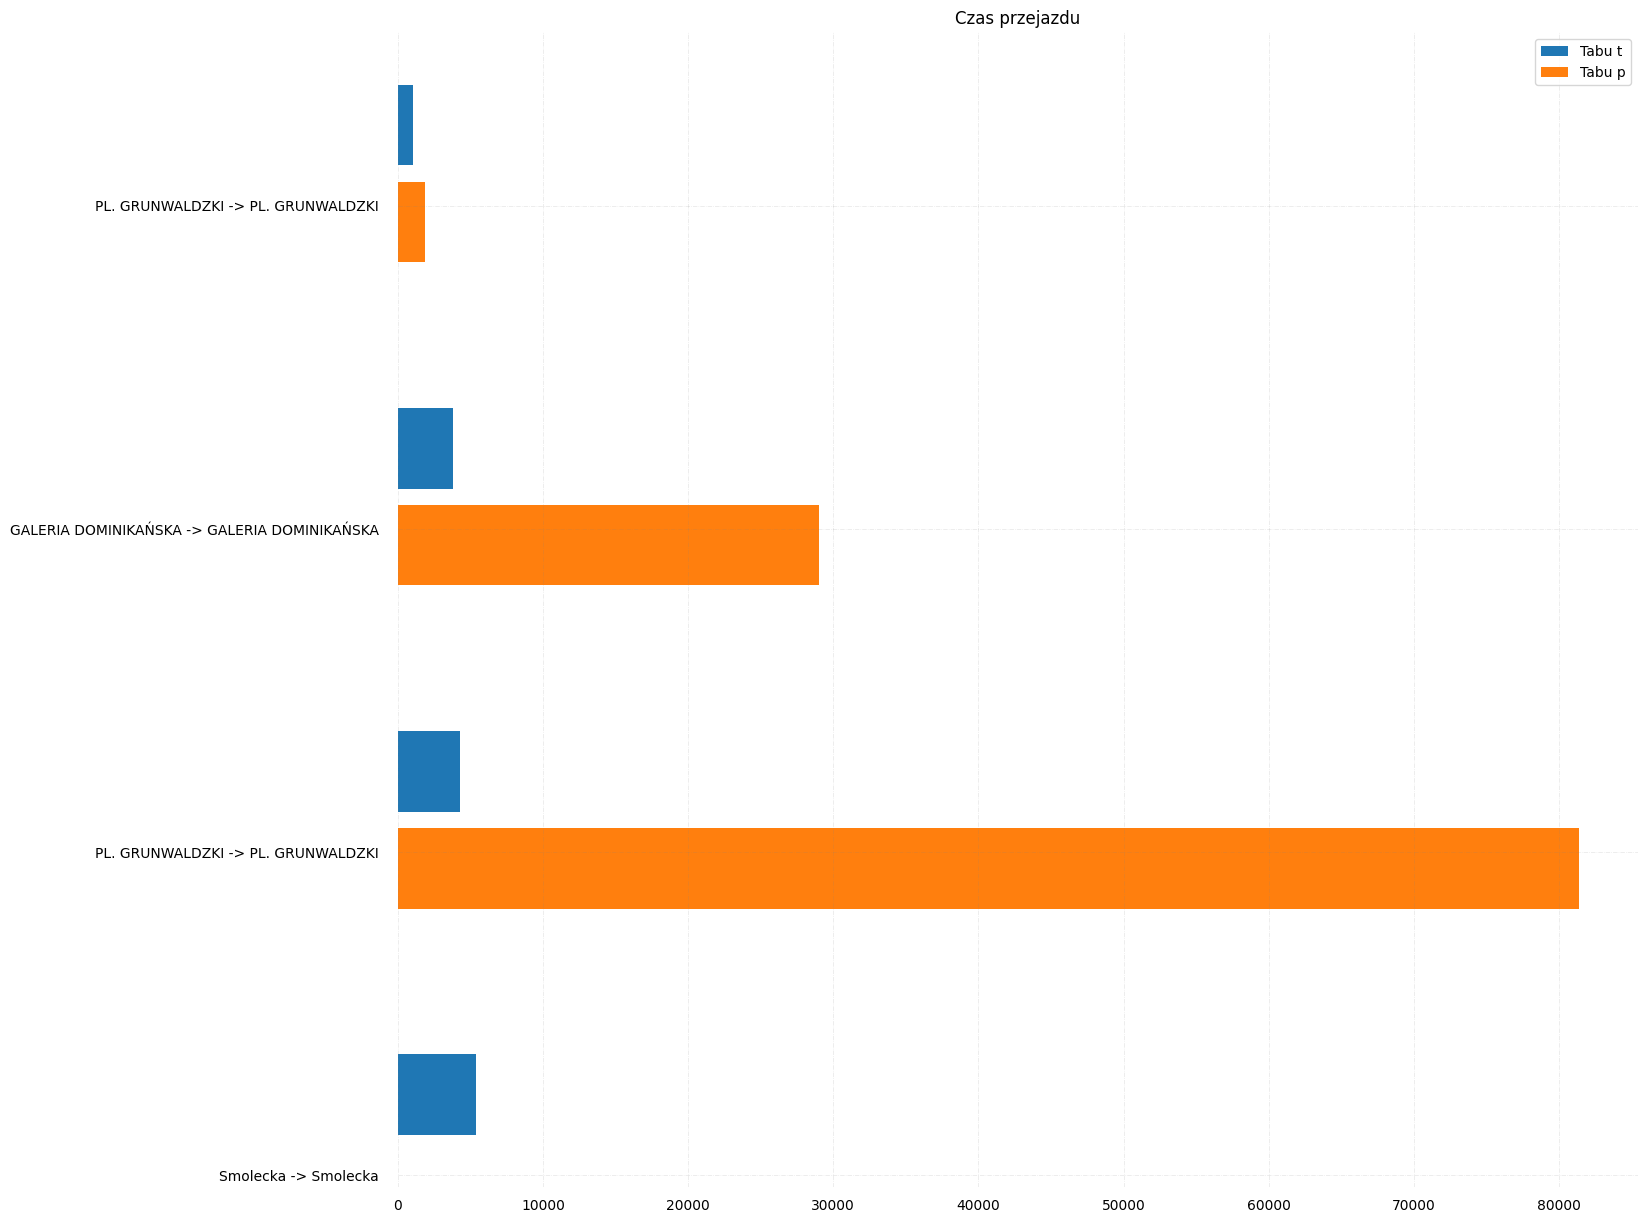

In [95]:
bar_plot_compare([results_t, results_p], ['Tabu t', 'Tabu p'], col_idx=1, title='Czas przejazdu', formatter=lambda x: x)

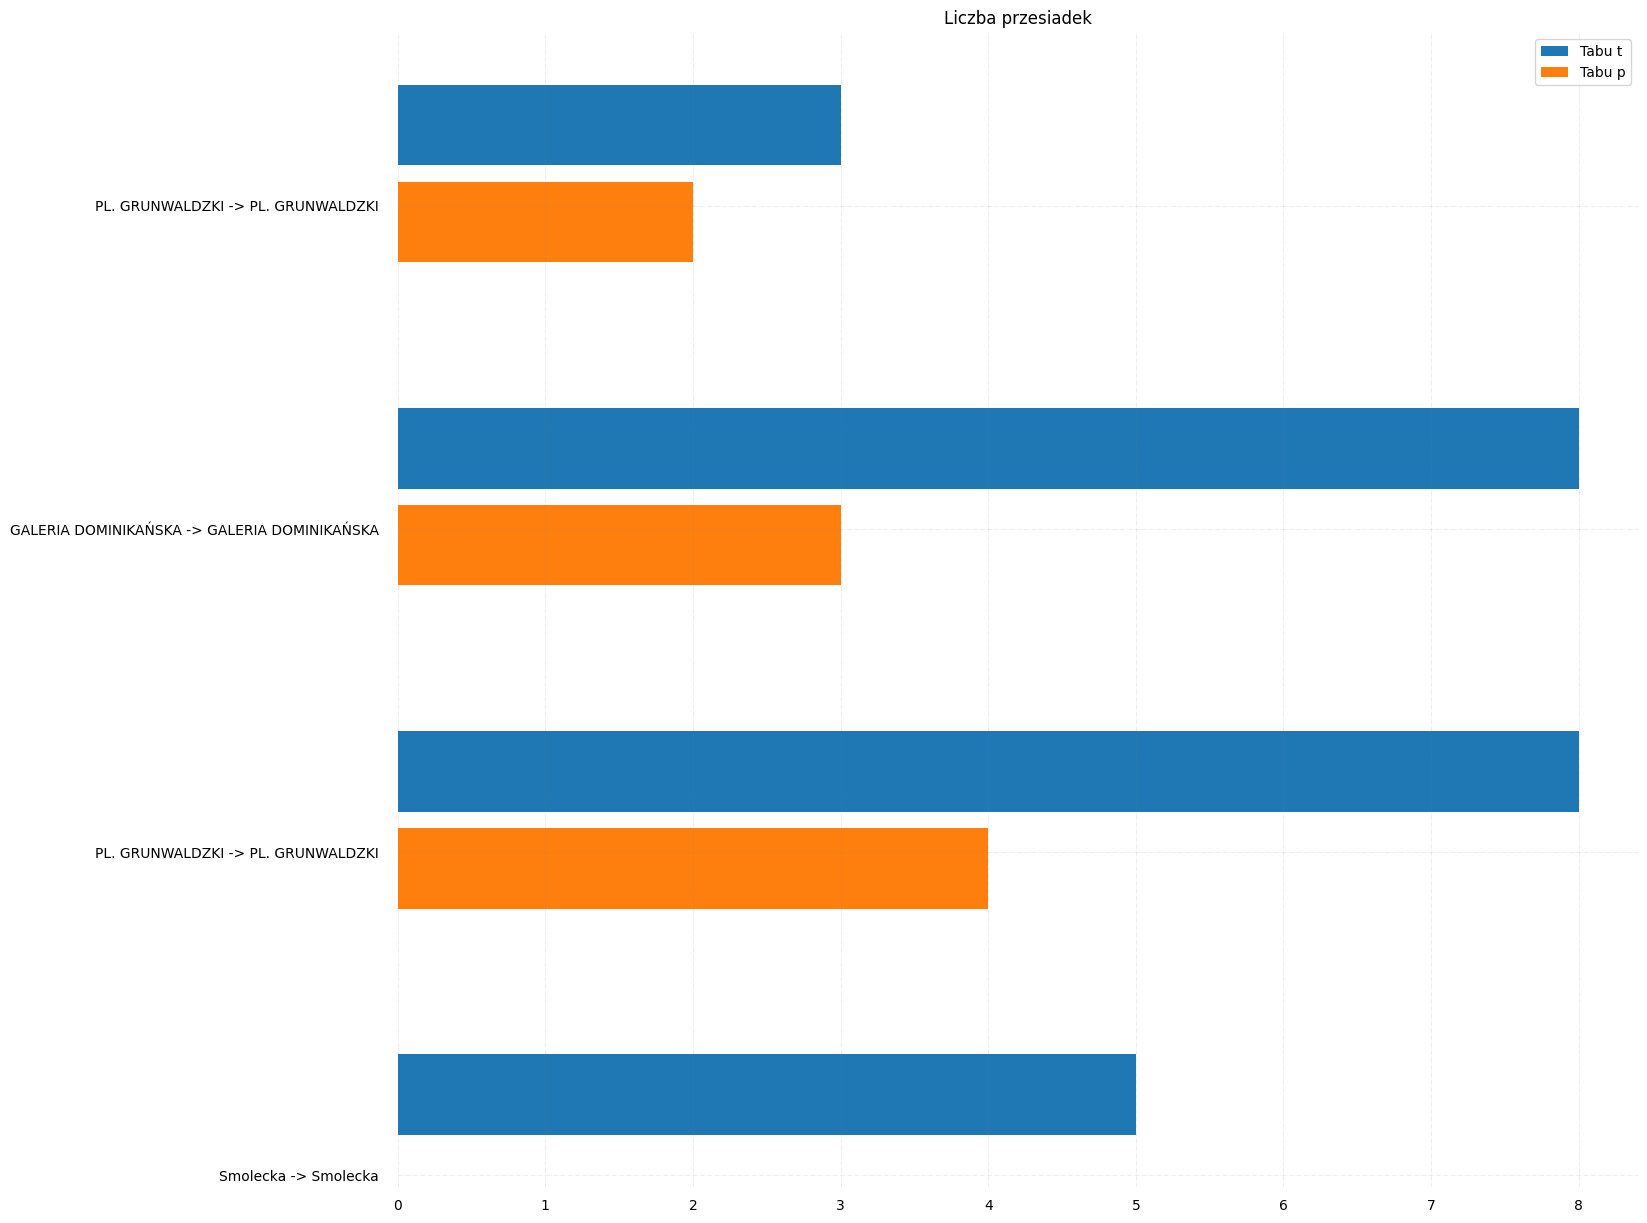

In [96]:
bar_plot_compare([results_t, results_p], ['Tabu t', 'Tabu p'], col_idx=2, title='Liczba przesiadek', formatter=int, display_annotation=False)

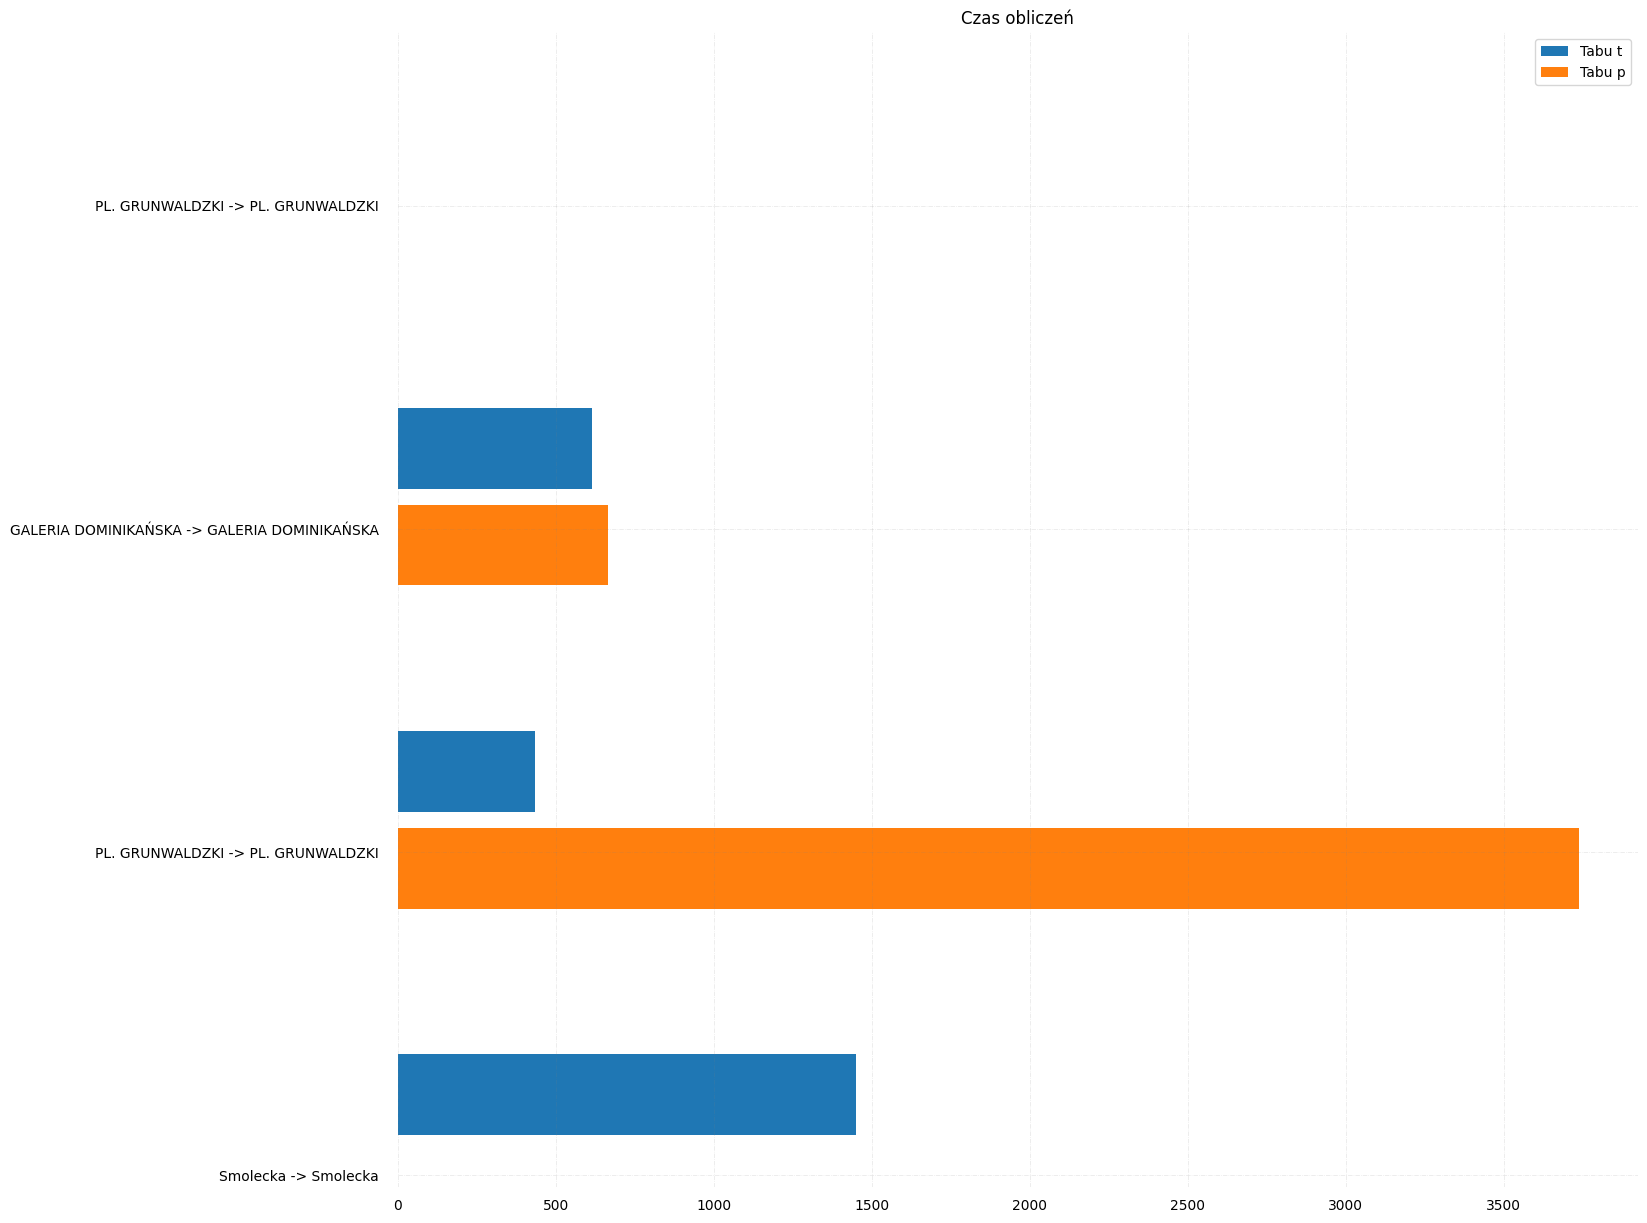

In [97]:
bar_plot_compare([results_t, results_p], ['Tabu t', 'Tabu p'], col_idx=6, title='Czas obliczeń', formatter=int)